# Simple practice on GAN
based on: <br>
https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

## Imports

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Setup
Placeholders, hyper parameters, definitions

In [2]:
tf.reset_default_graph()
batchSize = 256

XIn = tf.placeholder(dtype= tf.float32, shape=[None, 28,28], name='X')
Y = tf.placeholder(dtype= tf.float32, shape=[None, 28,28], name='Y')
YFlat = tf.reshape(Y,shape=[-1,28*28])
keepProb = tf.placeholder(dtype=tf.float32, shape = (), name='keepProb')

decInChannels = 1
nLatent = 8

reshapedDim = [-1,7,7,decInChannels]
inputDecoder = 49*decInChannels//2

def leakyRelu (x, alpha = 0.3):
    return tf.maximum(x,tf.multiply(x,alpha))

## Encoder

In [3]:
def encoder(XIn, keepProb):
    activation = leakyRelu
    with tf.variable_scope("encoder", reuse= None):
        X = tf.reshape(XIn, shape=[-1,28,28,1])
        # First Con2D layer and dropout
        x = tf.layers.conv2d(X, filters = 64, kernel_size=4, strides = 2, padding= 'same', activation=activation)
        x = tf.nn.dropout(x, keepProb)
        # Second Con2D layer and dropout
        x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides = 2, padding= 'same', activation=activation)
        x = tf.nn.dropout(x, keepProb)
        # Third Con2D layer and dropout
        x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides = 1, padding= 'same', activation=activation)
        x = tf.nn.dropout(x, keepProb)
        # Flattening
        x = tf.contrib.layers.flatten(x)
        # Vector of means
        mn = tf.layers.dense(x,units= nLatent)
        # vector of standard deviation
        sd = 0.5* tf.layers.dense(x,units= nLatent)
        
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], nLatent]))
        
        z = mn+tf.multiply(epsilon, tf.exp(sd))
        
        return z,mn,sd

## Decoder

In [4]:
def decoder(sampledZ, keepProb):
    with tf.variable_scope('decoder', reuse=None):
        # Two fully connected layer
        x= tf.layers.dense(sampledZ, units= inputDecoder, activation = leakyRelu)
        x = tf.layers.dense(x, units= inputDecoder*2+1, activation = leakyRelu)
        x = tf.reshape(x, reshapedDim)
        
        # First Conv2D trnaspose layer + dropout
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides= 2, padding = 'same', activation = tf.nn.relu)
        x = tf.nn.dropout(x, keepProb)
        
        # Second Conv2D trnaspose layer + dropout
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides= 1, padding = 'same', activation = tf.nn.relu)
        x = tf.nn.dropout(x, keepProb)
        
        # Third Conv2D trnaspose layer + dropout
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides= 1, padding = 'same', activation = tf.nn.relu)
        x = tf.nn.dropout(x, keepProb)
        
        # Flatting the model
        x= tf.contrib.layers.flatten(x)
        # Fully connected
        x = tf.layers.dense(x, units = 28*28, activation = tf.nn.sigmoid)
        
        # Convert the shape into a cevtor of 28*28 
        img = tf.reshape(x, shape = [-1,28,28])
        return img

## Compile

In [ ]:
%%time
sample, mn,sd = encoder(XIn, keepProb)
dec = decoder(sample,keepProb)

In [6]:
%%time
unreshaped = tf.reshape(dec, [-1,28*28])
imgLoss = tf.reduce_sum(tf.squared_difference(unreshaped, YFlat),1)
latentLoss = -0.5*tf.reduce_sum(10.+2.0*sd - tf.square(mn) - tf.exp(2.0*sd),1)
loss= tf.reduce_mean (imgLoss + latentLoss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

Wall time: 738 ms


In [7]:
%%time
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Wall time: 1.68 s


# Train the model

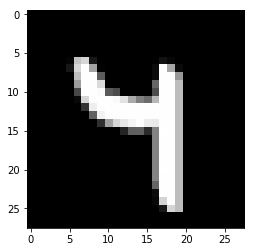

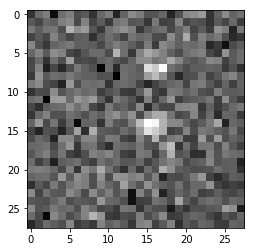

0 140.798 176.795 -35.9968


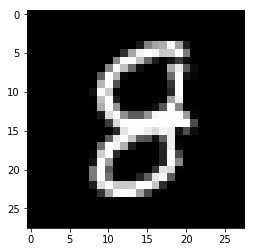

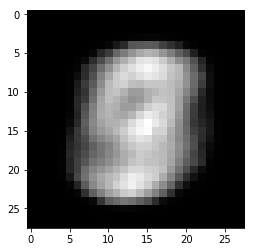

100 14.6074 49.7383 -35.1309


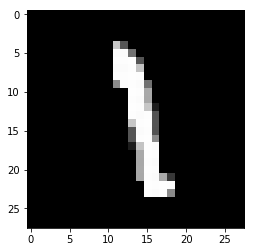

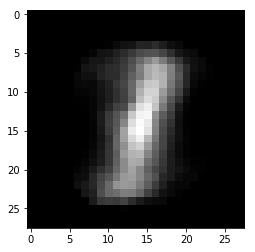

200 12.1651 45.9676 -33.8025


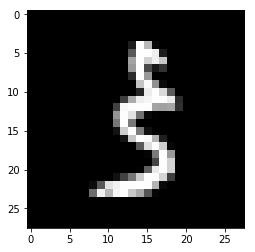

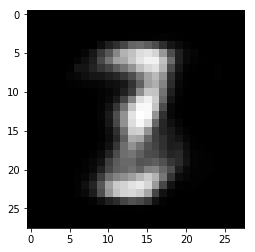

300 4.37995 33.9416 -29.5617


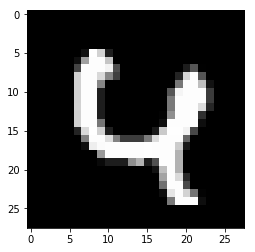

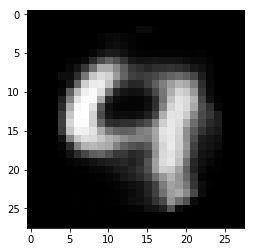

400 0.768922 29.5913 -28.8223


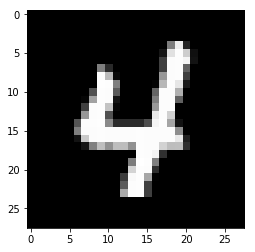

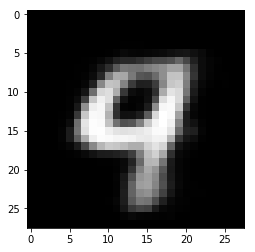

500 -1.07171 26.9216 -27.9933


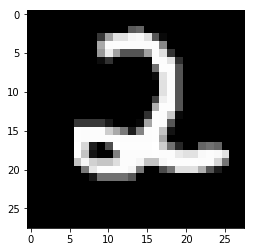

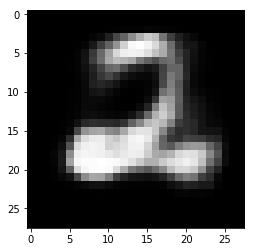

600 -2.56439 25.7621 -28.3265


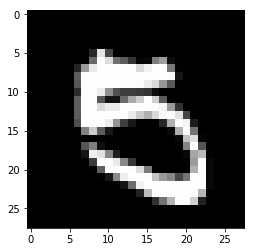

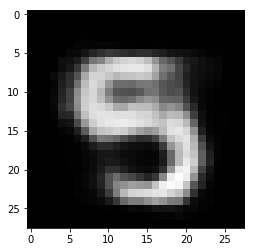

700 -2.11687 25.3863 -27.5032


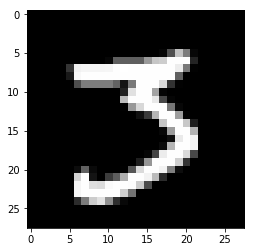

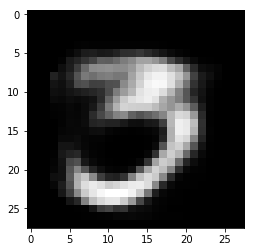

800 -4.30203 22.7902 -27.0922


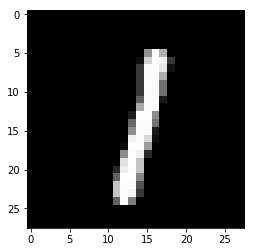

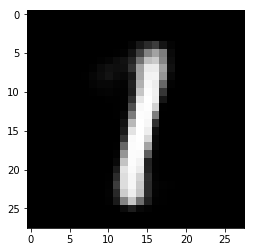

900 -5.62116 21.6556 -27.2768


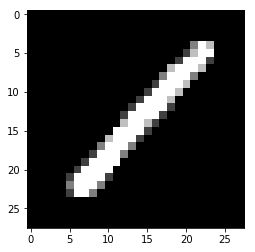

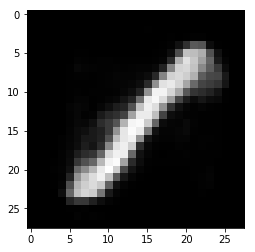

1000 -5.71856 21.655 -27.3736


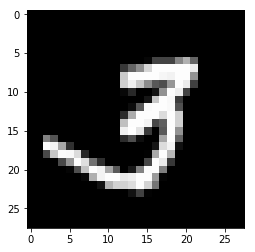

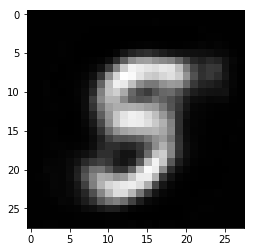

1100 -2.83462 24.651 -27.4856


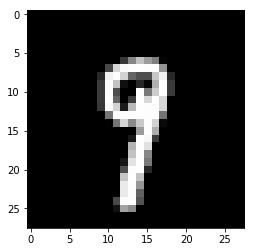

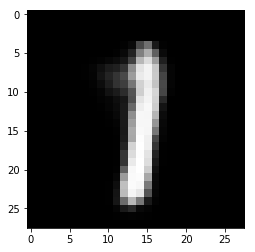

1200 -4.46956 22.3665 -26.8361


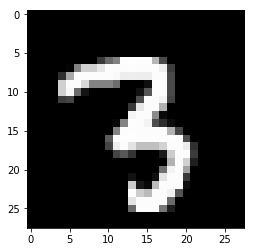

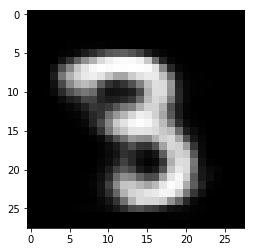

1300 -5.00926 21.5658 -26.5751


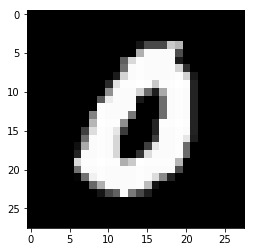

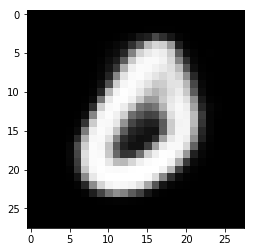

1400 -5.45151 21.3226 -26.7741


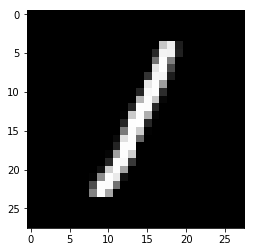

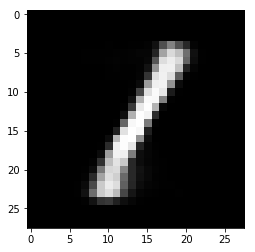

1500 -6.23333 20.248 -26.4813


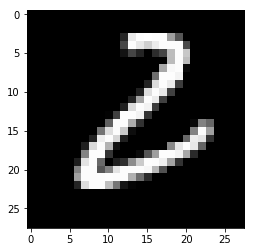

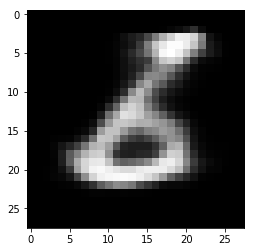

1600 -6.33607 20.0057 -26.3418


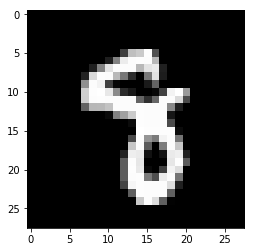

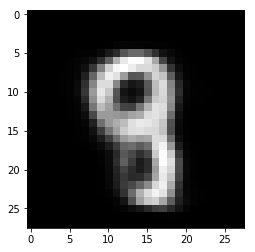

1700 -5.68964 20.9486 -26.6382


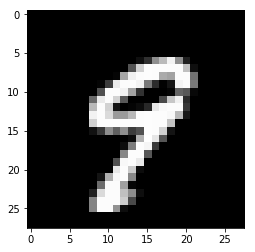

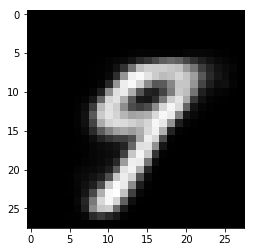

1800 -6.19888 20.3913 -26.5902


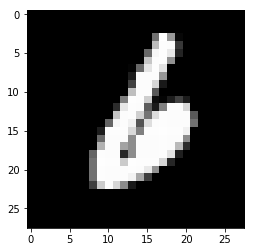

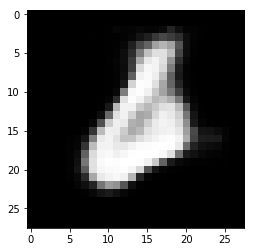

1900 -6.11438 20.7615 -26.8759


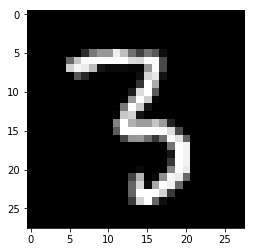

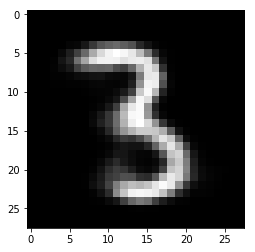

2000 -5.77411 20.5803 -26.3544


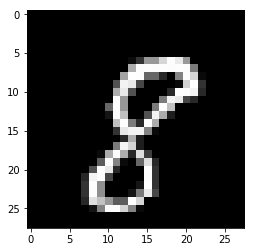

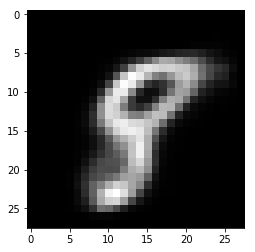

2100 -5.75239 21.0479 -26.8003


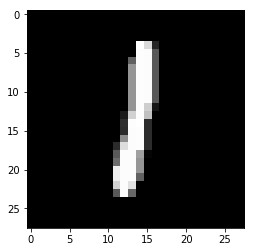

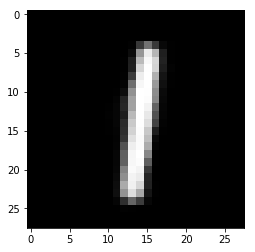

2200 -6.78462 19.39 -26.1747


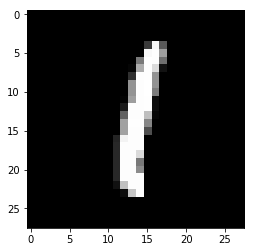

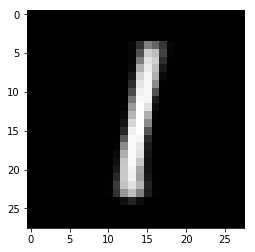

2300 -5.73827 20.4393 -26.1776


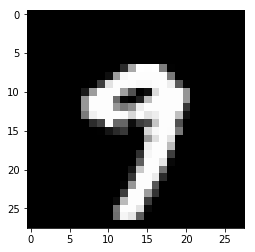

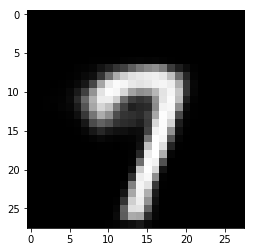

2400 -6.34139 20.2394 -26.5808


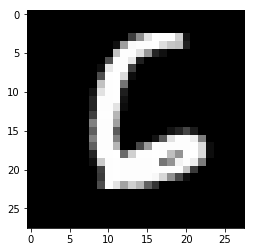

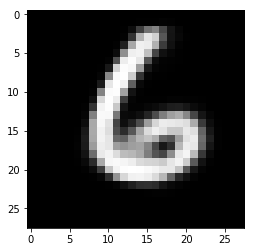

2500 -5.62083 20.4 -26.0208


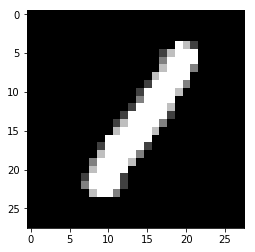

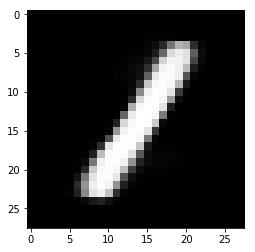

2600 -5.87719 20.4588 -26.336


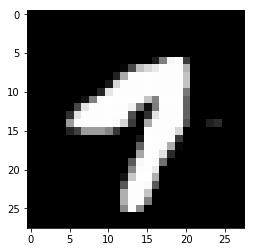

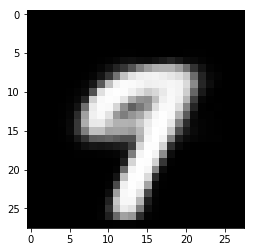

2700 -6.823 19.2707 -26.0937


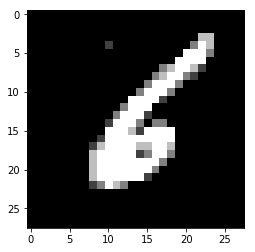

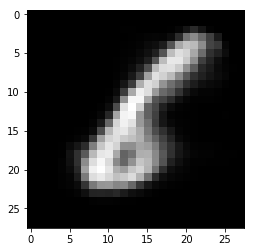

2800 -7.14693 18.8021 -25.949


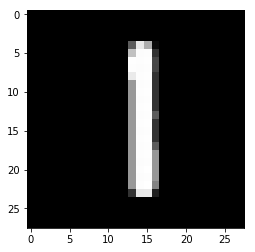

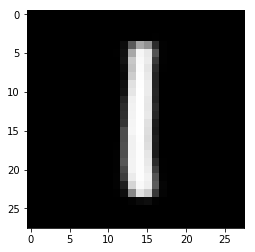

2900 -7.32163 19.0609 -26.3826


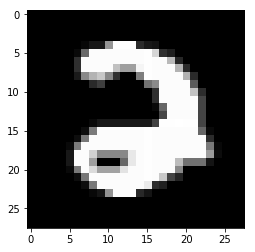

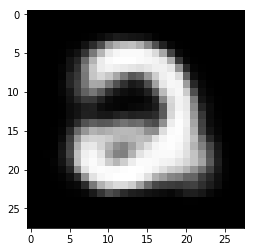

3000 -8.29976 17.8733 -26.1731


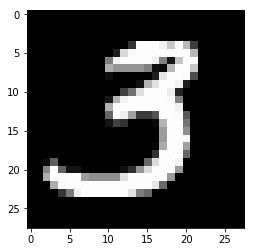

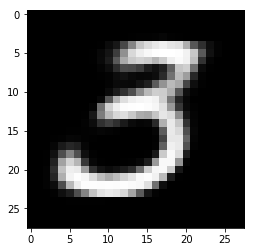

3100 -8.06207 18.0788 -26.1408


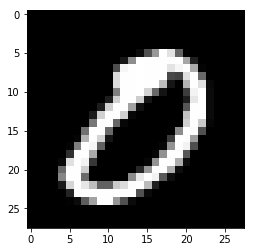

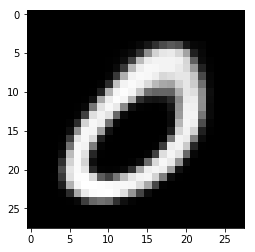

3200 -7.29069 18.7418 -26.0325


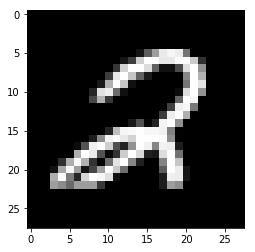

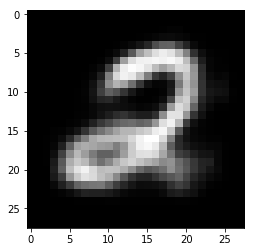

3300 -6.96855 19.0478 -26.0163


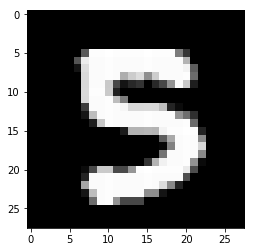

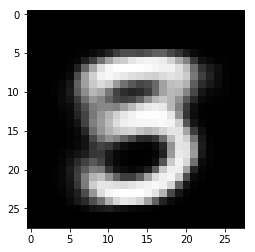

3400 -6.03938 20.1042 -26.1436


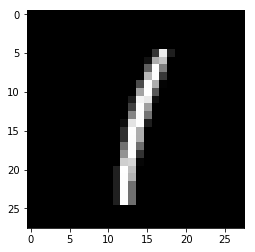

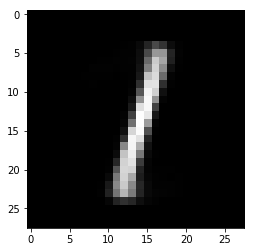

3500 -6.00251 20.0249 -26.0274


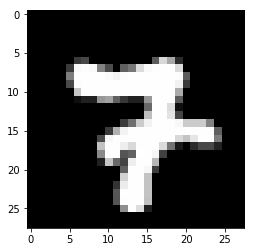

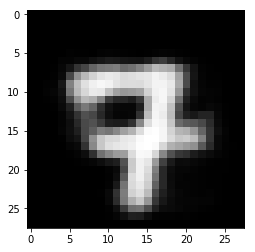

3600 -7.56975 18.3221 -25.8918


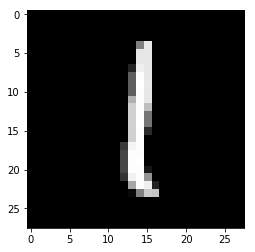

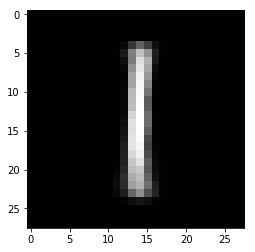

3700 -6.5324 19.6054 -26.1378


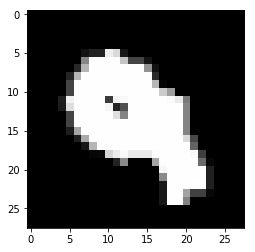

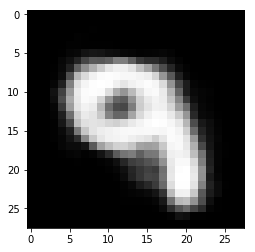

3800 -6.91615 18.9437 -25.8599


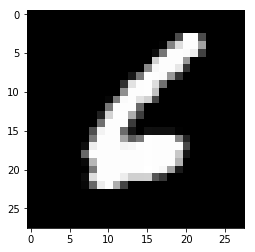

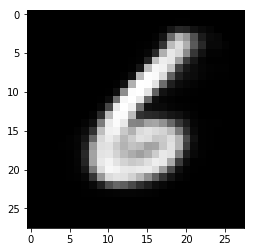

3900 -7.12996 18.6569 -25.7869


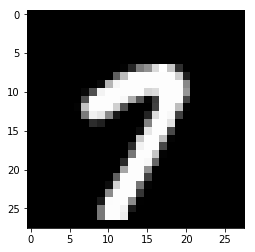

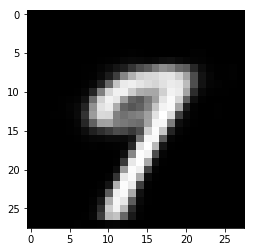

4000 -7.03746 18.6829 -25.7204


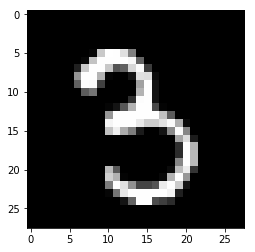

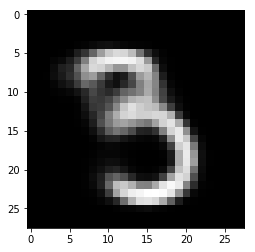

4100 -7.64087 18.4702 -26.1111


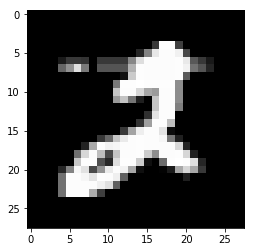

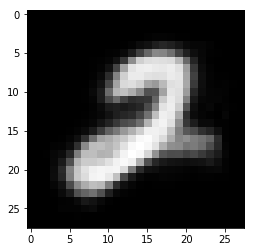

4200 -9.16779 16.8429 -26.0107


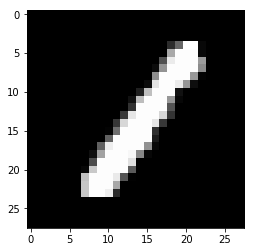

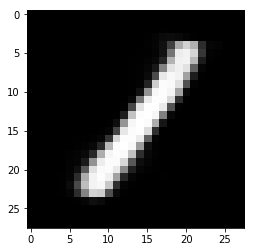

4300 -7.98595 18.0495 -26.0355


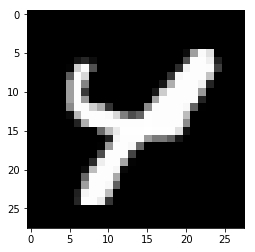

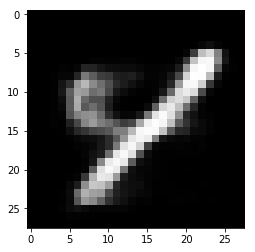

4400 -7.82986 17.8359 -25.6658


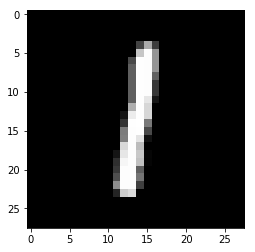

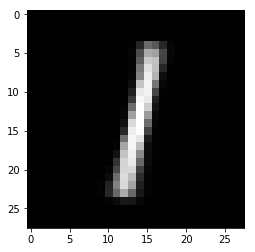

4500 -7.5311 18.1764 -25.7075


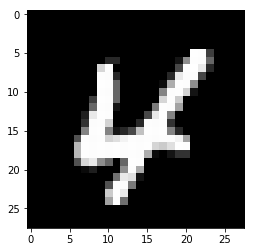

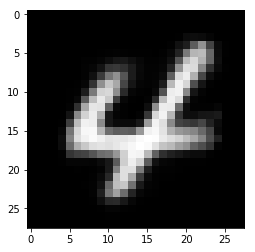

4600 -7.33568 18.283 -25.6187


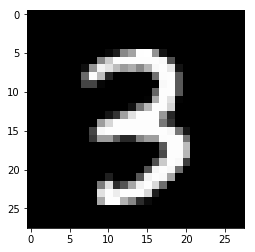

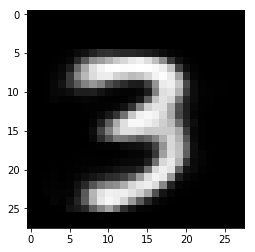

4700 -7.5385 18.5972 -26.1357


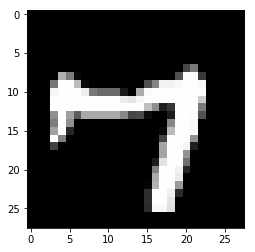

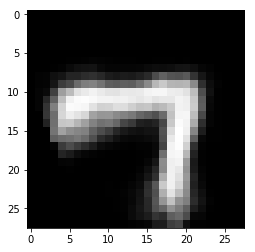

4800 -7.95415 17.8328 -25.7869


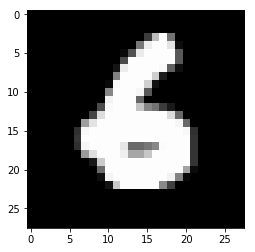

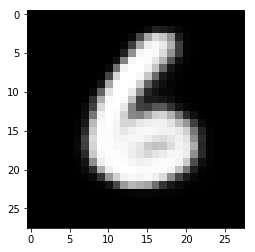

4900 -7.23459 18.6433 -25.8779


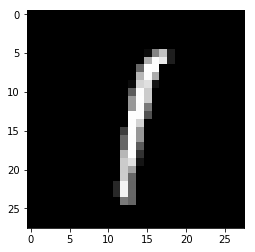

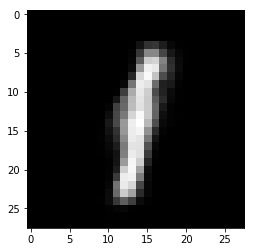

5000 -8.17624 17.5493 -25.7256


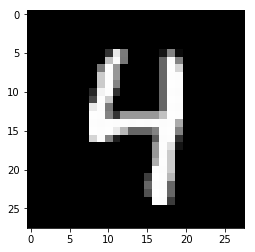

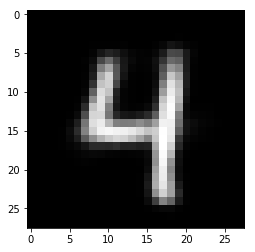

5100 -7.69848 18.0126 -25.7111


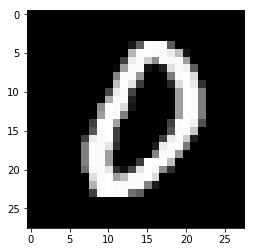

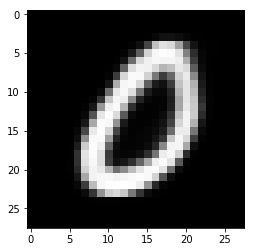

5200 -7.58987 18.6208 -26.2107


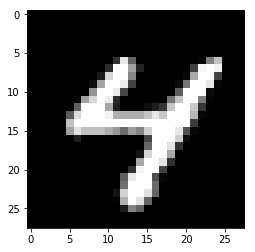

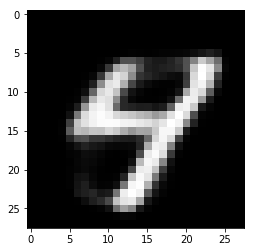

5300 -7.77341 17.9717 -25.7451


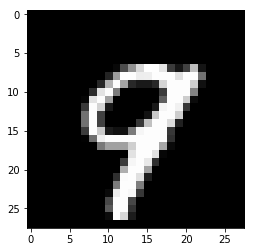

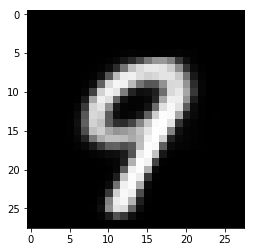

5400 -8.46634 16.8337 -25.3


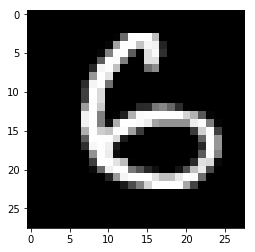

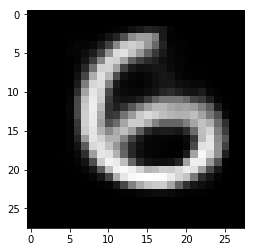

5500 -7.74824 17.837 -25.5853


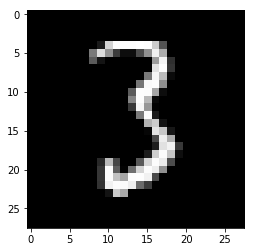

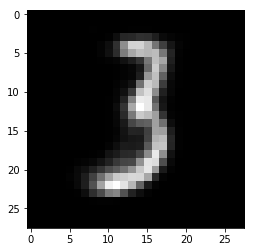

5600 -7.13421 18.6936 -25.8278


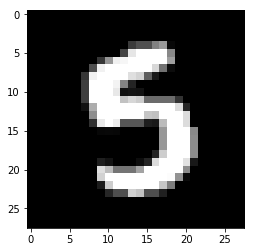

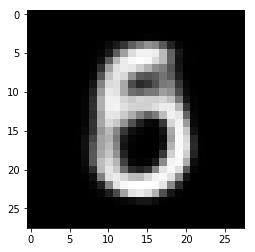

5700 -8.95421 17.0257 -25.9799


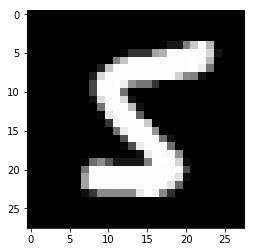

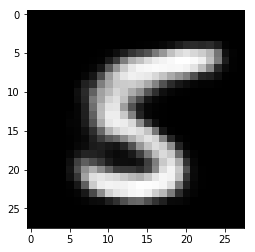

5800 -6.85246 18.9681 -25.8206


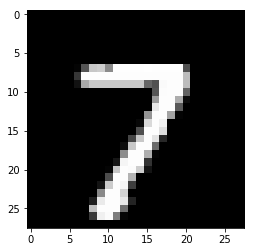

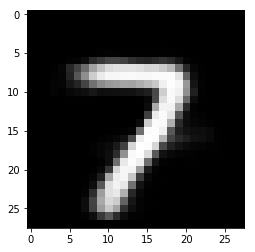

5900 -7.84476 17.7066 -25.5514


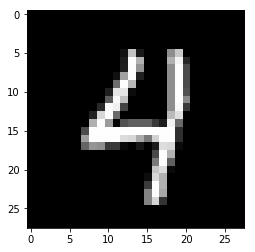

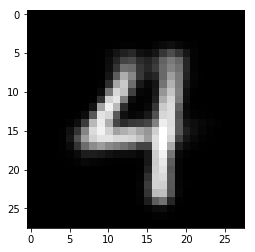

6000 -8.445 17.6773 -26.1223


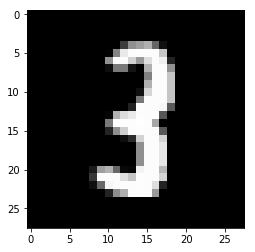

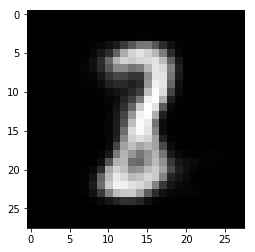

6100 -9.13861 16.4644 -25.603


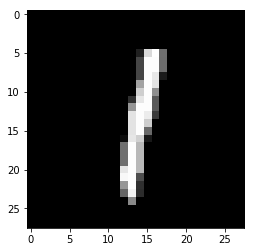

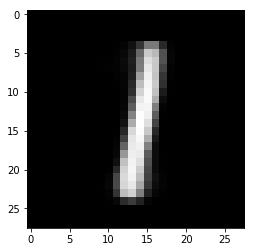

6200 -7.29582 18.4514 -25.7472


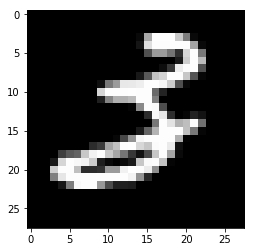

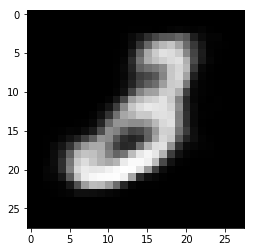

6300 -8.38934 17.4653 -25.8546


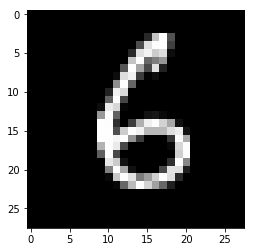

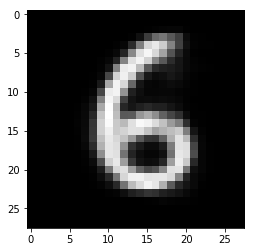

6400 -8.29917 17.3404 -25.6396


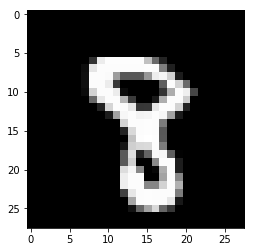

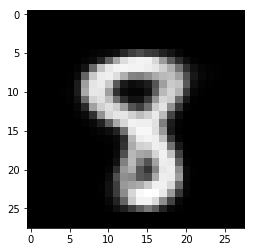

6500 -8.05257 17.3895 -25.4421


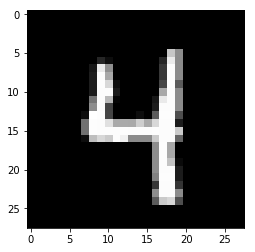

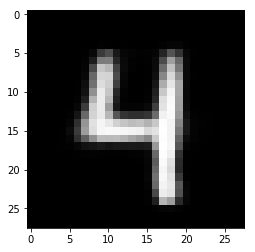

6600 -8.18567 17.6073 -25.793


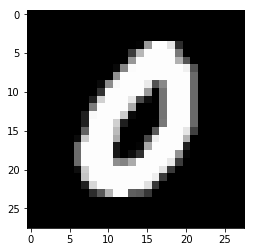

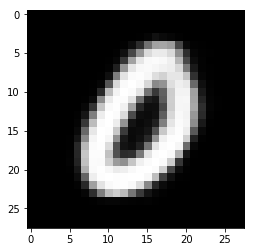

6700 -8.27479 17.1258 -25.4006


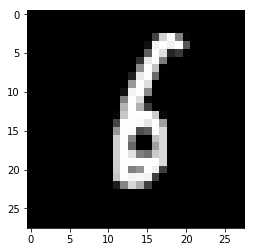

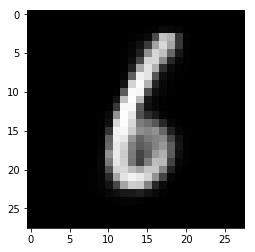

6800 -7.95252 17.774 -25.7266


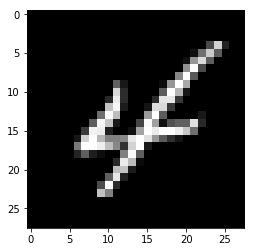

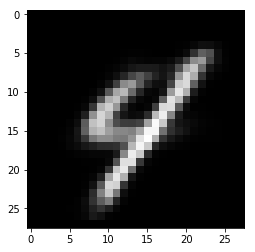

6900 -8.4417 16.9415 -25.3832


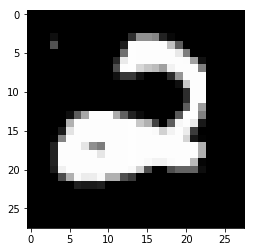

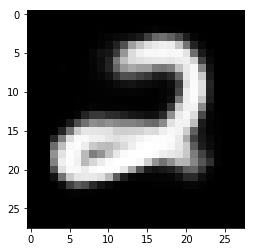

7000 -8.39753 17.2689 -25.6664


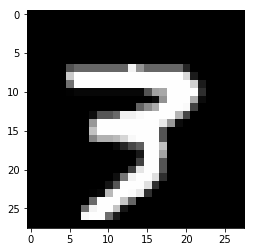

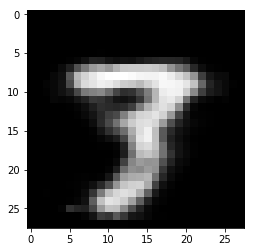

7100 -8.25496 17.1266 -25.3816


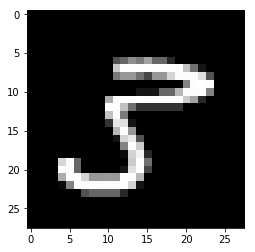

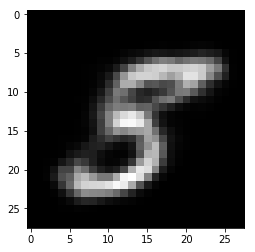

7200 -7.23547 18.2071 -25.4425


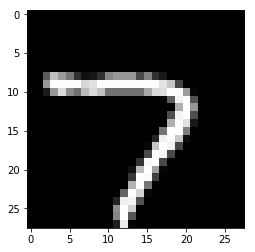

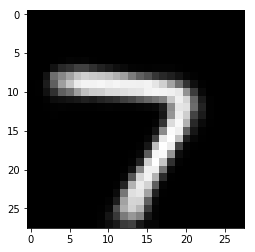

7300 -8.19507 17.2835 -25.4785


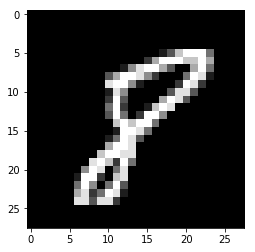

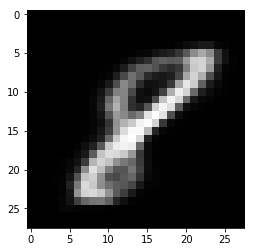

7400 -8.78619 16.6325 -25.4187


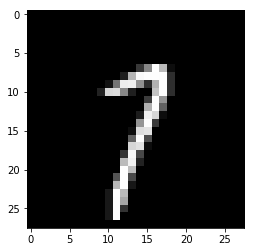

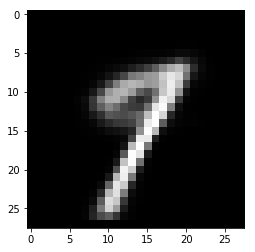

7500 -8.03903 17.6687 -25.7077


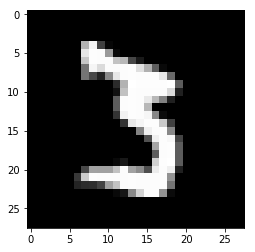

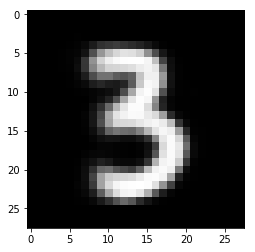

7600 -8.59513 16.9738 -25.5689


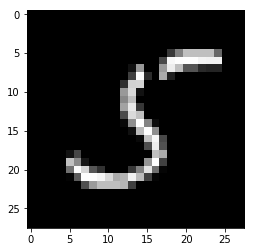

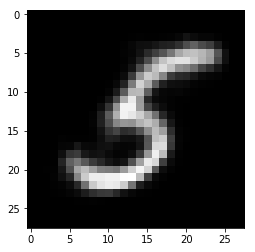

7700 -8.92142 16.3046 -25.226


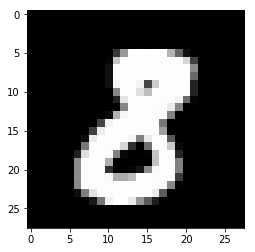

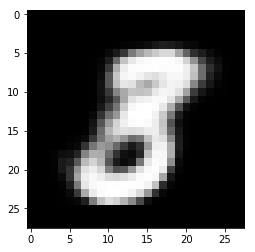

7800 -8.36712 17.051 -25.4181


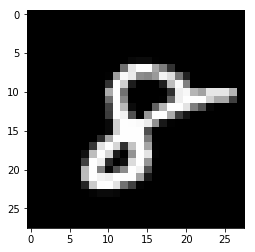

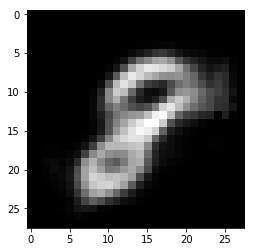

7900 -8.7341 16.3647 -25.0988


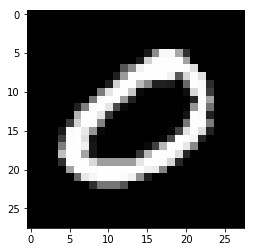

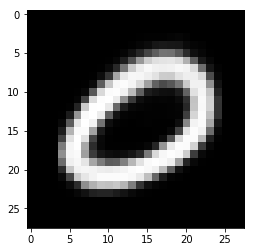

8000 -8.23236 17.3495 -25.5818


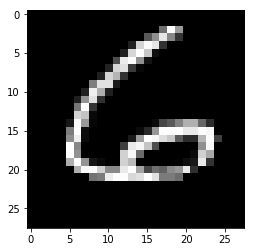

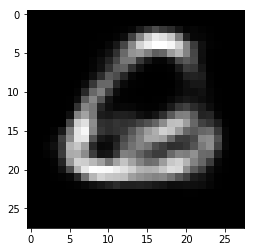

8100 -8.50428 16.8805 -25.3848


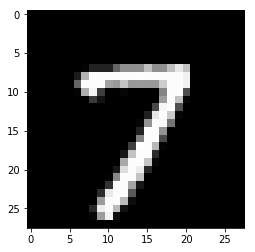

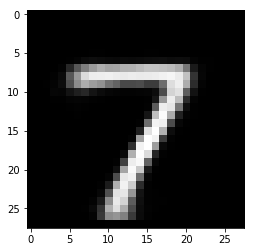

8200 -8.63608 16.7589 -25.395


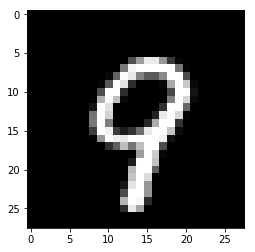

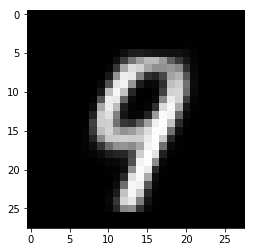

8300 -9.14183 16.077 -25.2189


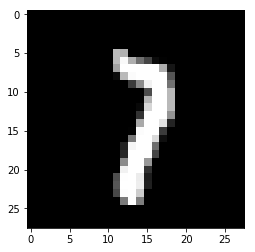

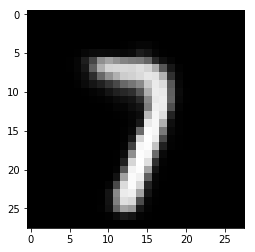

8400 -8.13823 17.4069 -25.5451


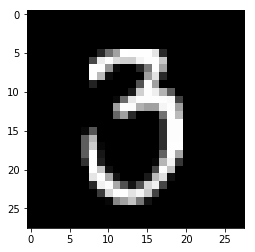

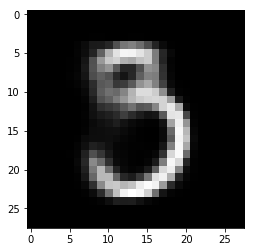

8500 -9.0937 16.3761 -25.4698


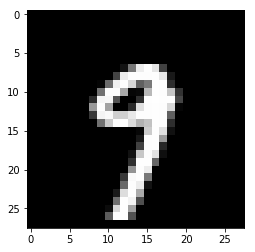

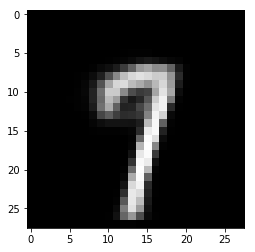

8600 -8.6414 16.5866 -25.228


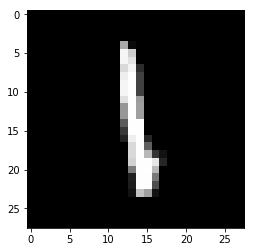

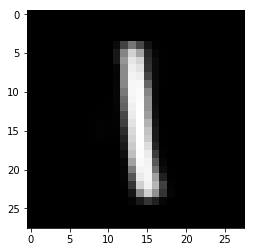

8700 -9.27707 16.0379 -25.315


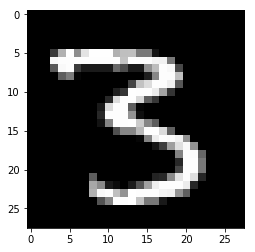

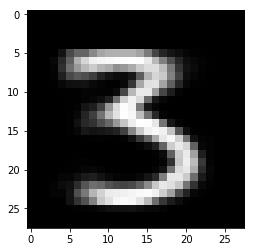

8800 -8.20558 17.2635 -25.4691


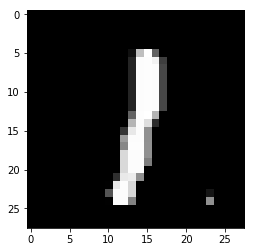

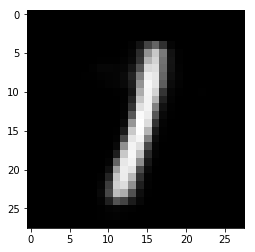

8900 -8.07084 17.525 -25.5959


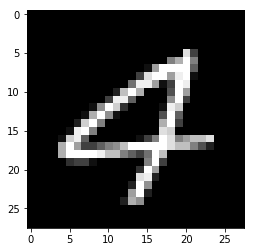

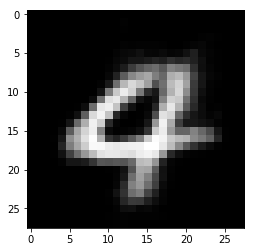

9000 -8.00962 17.3947 -25.4044


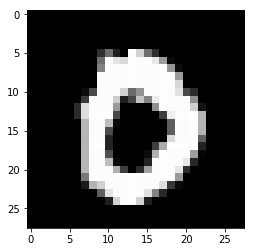

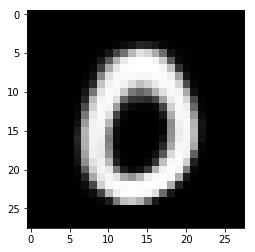

9100 -8.30817 17.1969 -25.5051


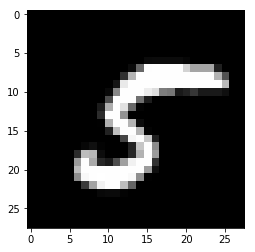

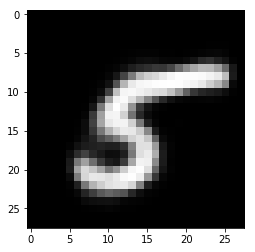

9200 -8.65736 17.0311 -25.6885


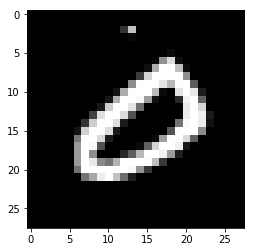

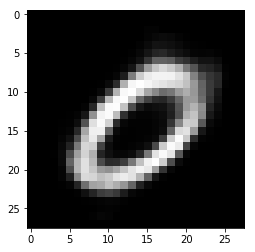

9300 -8.07775 17.2065 -25.2842


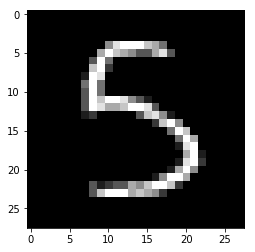

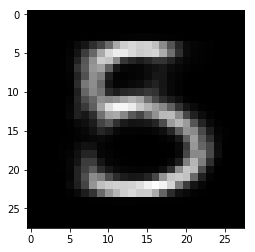

9400 -8.85329 16.549 -25.4023


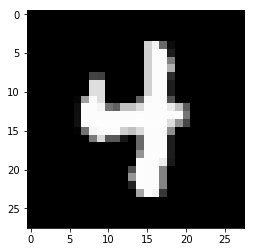

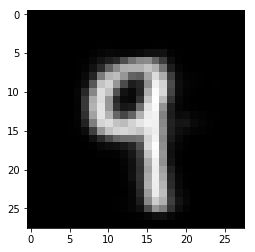

9500 -9.31967 15.9461 -25.2657


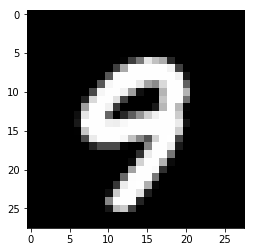

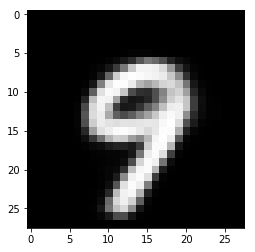

9600 -8.61205 16.7771 -25.3892


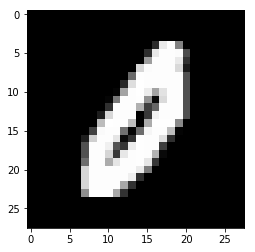

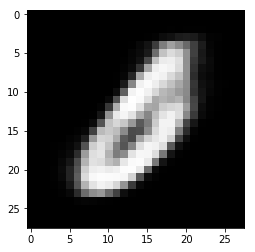

9700 -8.56484 16.9523 -25.5171


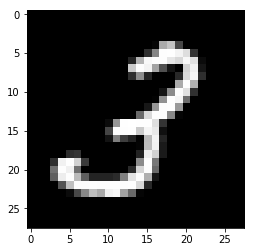

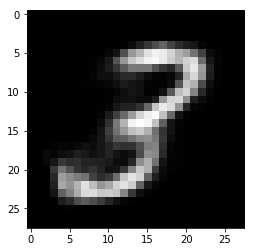

9800 -8.99712 16.2111 -25.2082


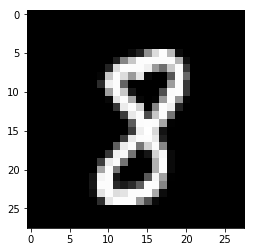

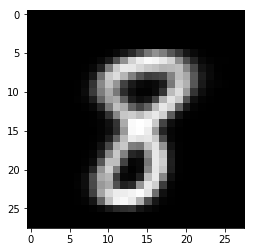

9900 -7.71776 17.3342 -25.0519


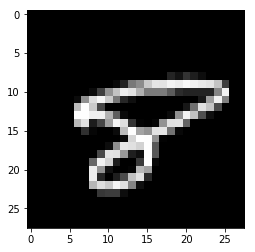

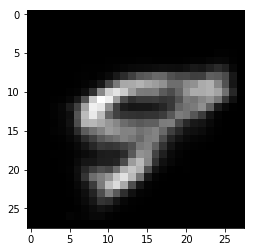

10000 -7.74622 17.4885 -25.2348


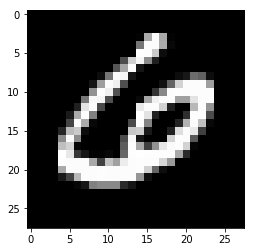

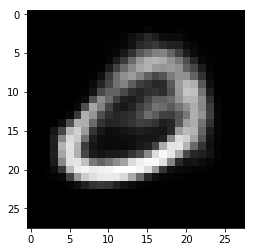

10100 -8.63707 16.495 -25.1321


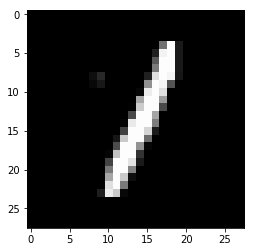

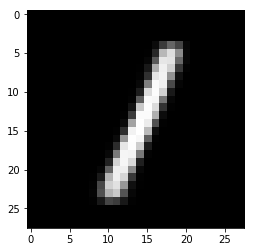

10200 -8.71151 16.9421 -25.6537


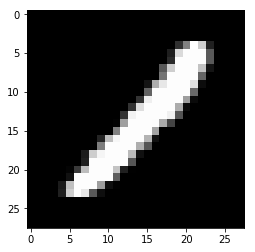

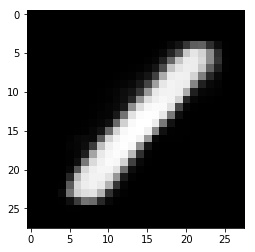

10300 -8.63199 16.3433 -24.9753


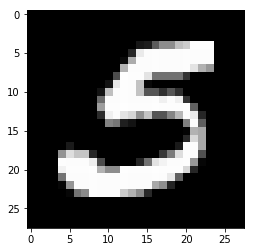

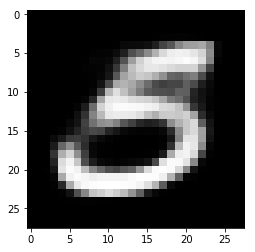

10400 -8.3112 17.0524 -25.3636


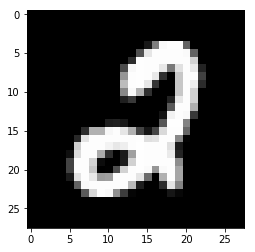

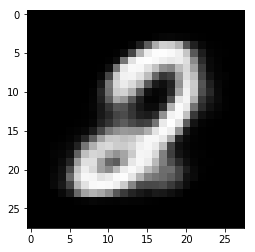

10500 -9.1628 16.5478 -25.7106


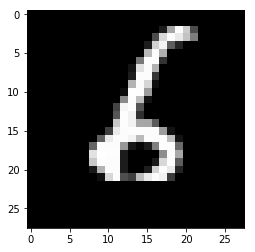

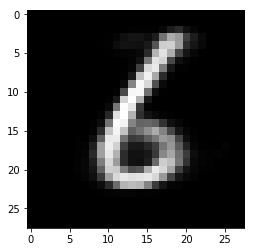

10600 -9.05053 16.3961 -25.4466


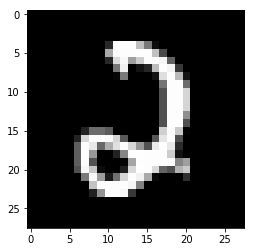

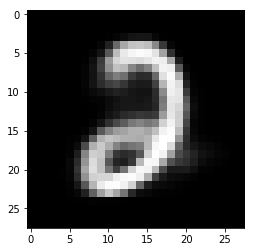

10700 -7.82232 17.3807 -25.203


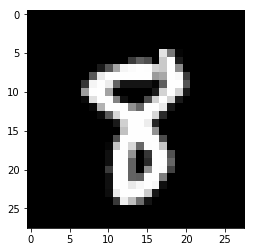

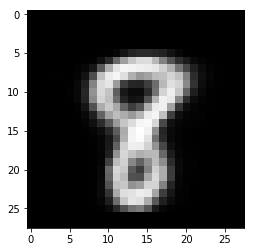

10800 -7.77491 17.5768 -25.3517


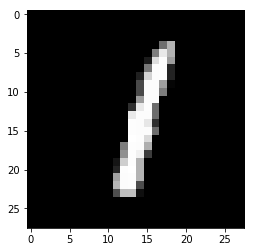

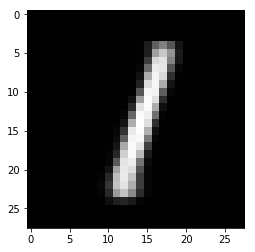

10900 -7.76272 17.5208 -25.2835


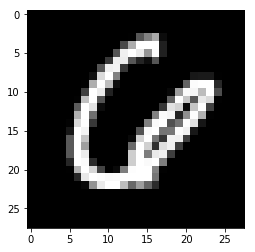

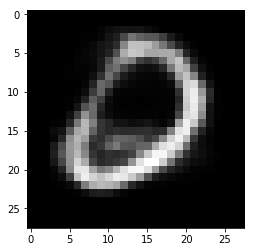

11000 -8.84645 16.054 -24.9005


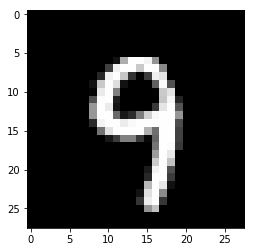

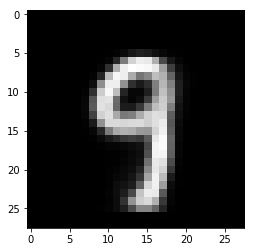

11100 -9.14491 16.4039 -25.5488


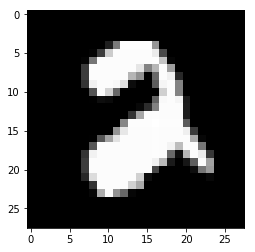

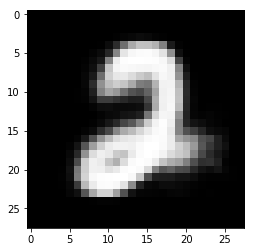

11200 -8.41975 17.0301 -25.4498


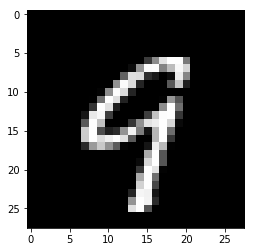

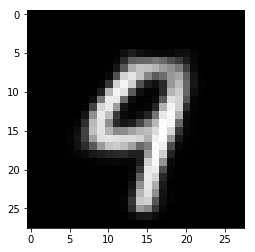

11300 -9.71095 15.9871 -25.698


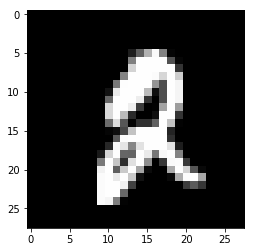

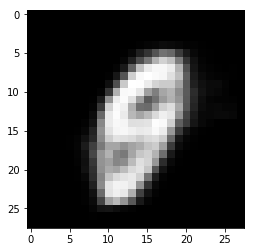

11400 -8.45023 16.6171 -25.0673


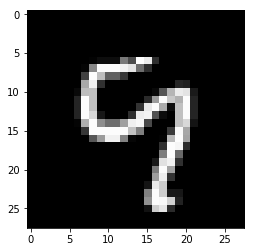

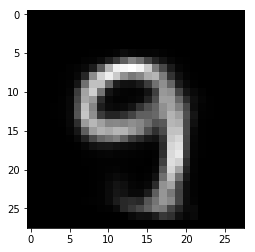

11500 -8.91588 16.7665 -25.6824


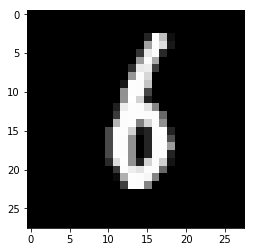

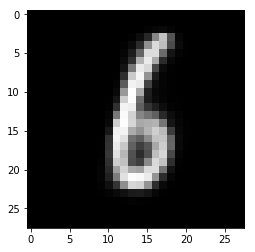

11600 -9.09246 16.1564 -25.2488


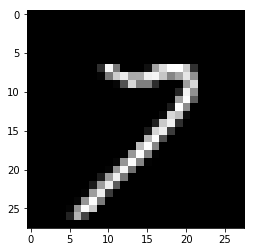

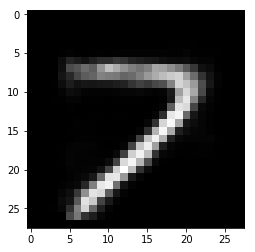

11700 -10.2963 15.1623 -25.4586


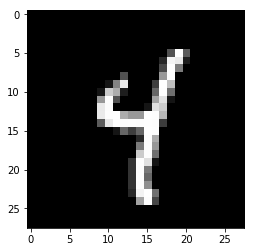

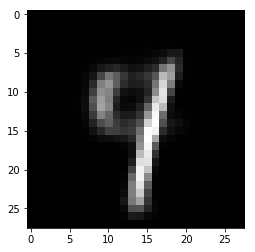

11800 -8.86323 16.5212 -25.3844


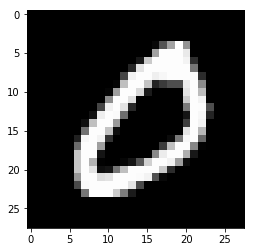

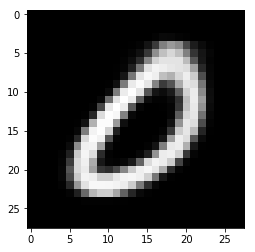

11900 -8.96474 16.2425 -25.2072


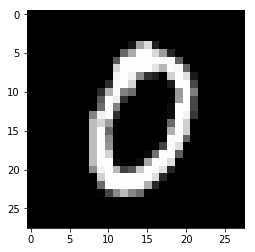

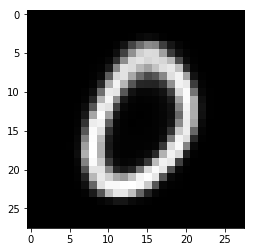

12000 -9.37519 16.1603 -25.5355


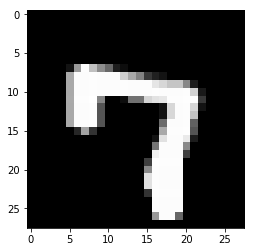

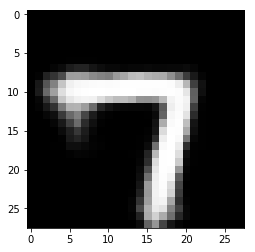

12100 -9.40332 15.9176 -25.321


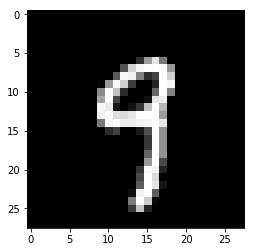

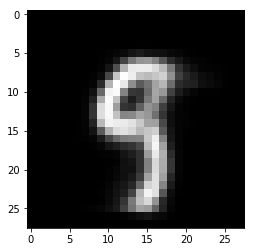

12200 -8.34566 16.9189 -25.2646


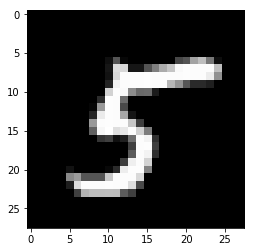

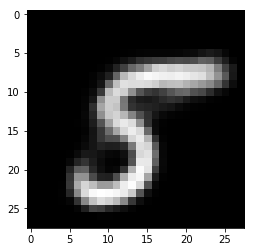

12300 -9.29521 15.9018 -25.197


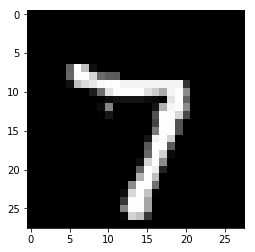

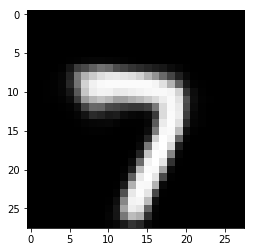

12400 -8.38039 16.7727 -25.1531


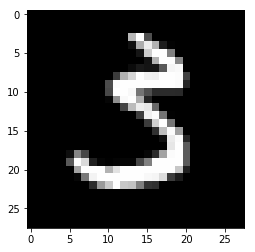

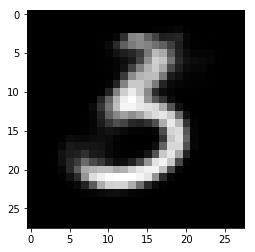

12500 -9.68894 15.7725 -25.4614


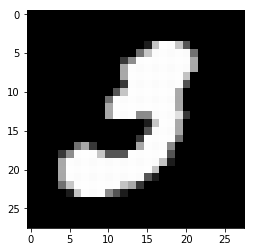

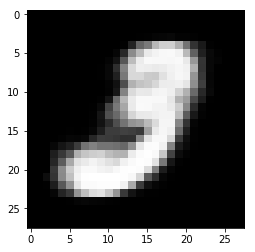

12600 -9.21537 15.832 -25.0473


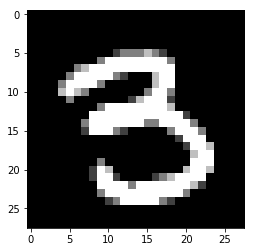

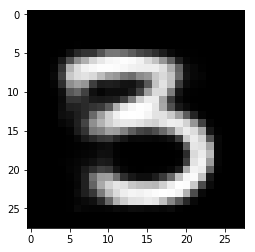

12700 -9.61847 15.6812 -25.2997


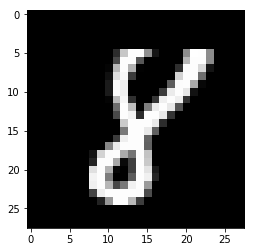

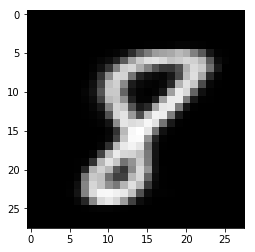

12800 -9.27503 15.7473 -25.0223


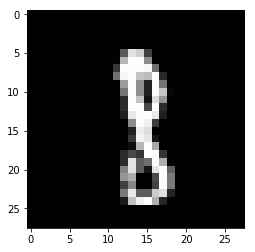

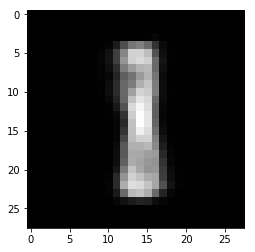

12900 -8.74035 16.5084 -25.2487


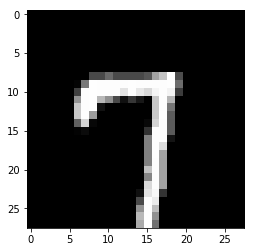

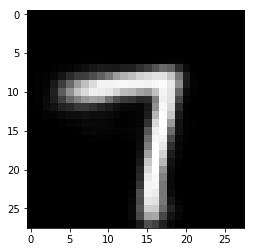

13000 -9.2915 15.9692 -25.2607


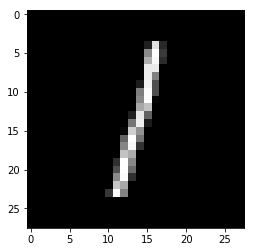

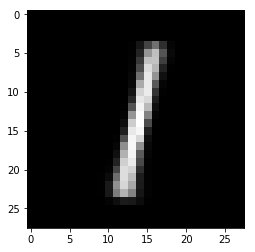

13100 -8.5456 17.0277 -25.5733


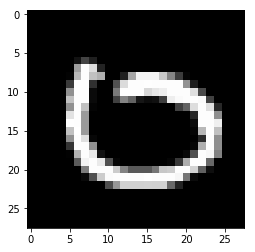

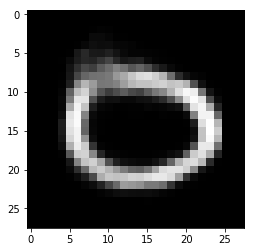

13200 -8.95057 16.5615 -25.5121


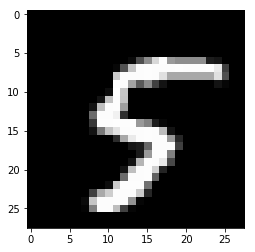

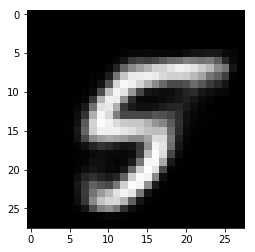

13300 -8.34083 16.9757 -25.3166


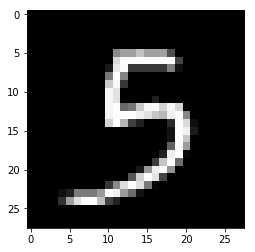

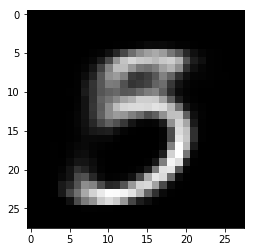

13400 -8.84805 16.4527 -25.3007


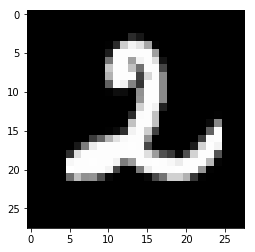

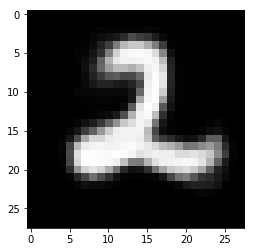

13500 -9.38458 16.0578 -25.4424


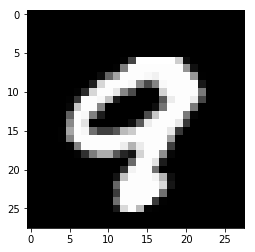

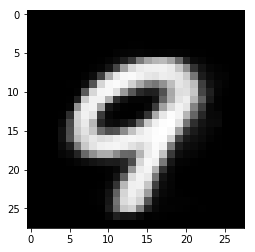

13600 -9.64891 15.6101 -25.259


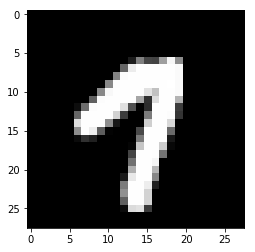

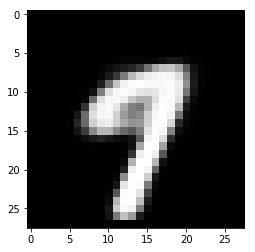

13700 -8.92736 16.0079 -24.9353


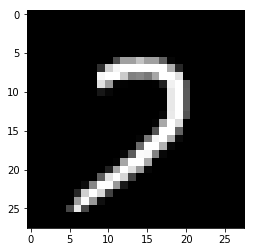

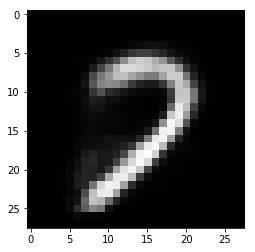

13800 -9.32477 15.9566 -25.2814


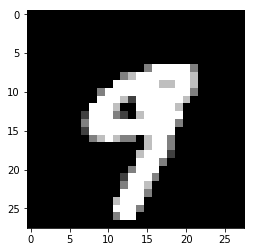

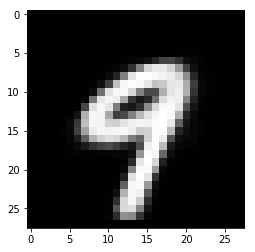

13900 -9.30637 16.0831 -25.3894


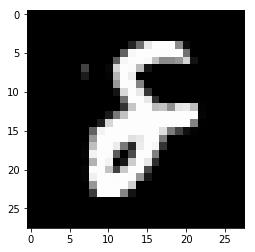

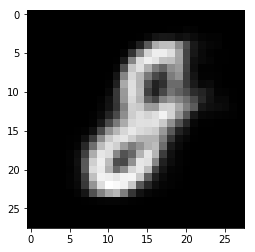

14000 -8.48945 16.5319 -25.0213


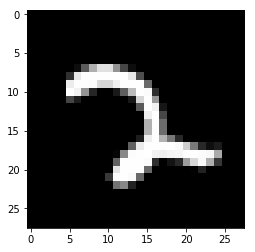

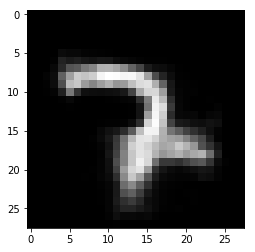

14100 -10.0962 15.3385 -25.4347


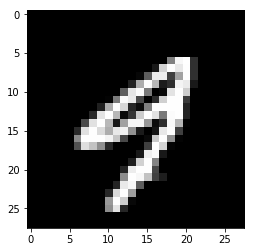

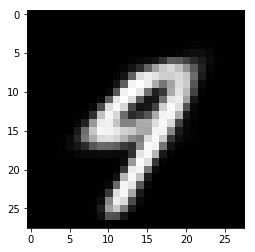

14200 -9.73938 15.4331 -25.1725


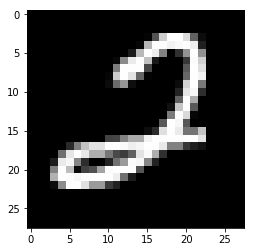

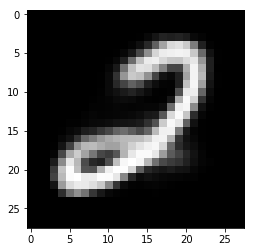

14300 -8.88744 16.5857 -25.4731


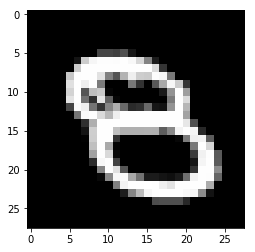

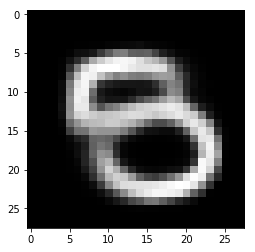

14400 -9.36724 15.7793 -25.1465


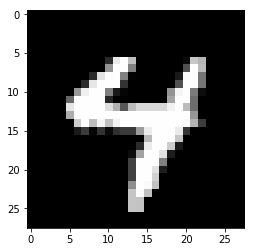

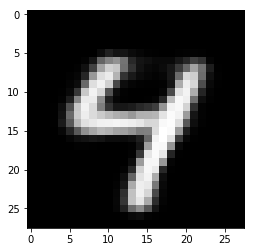

14500 -9.82574 15.5471 -25.3728


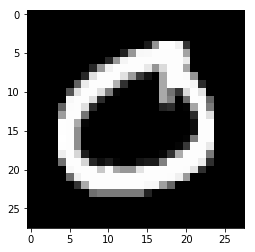

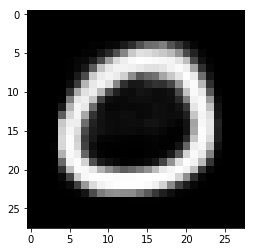

14600 -8.81931 16.2095 -25.0289


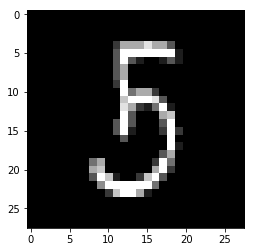

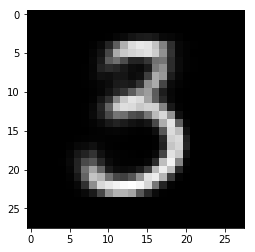

14700 -8.62395 16.5374 -25.1613


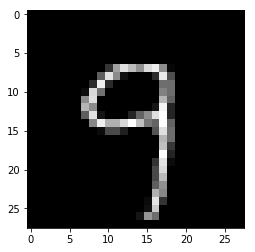

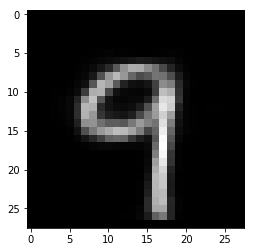

14800 -9.47716 15.7948 -25.2719


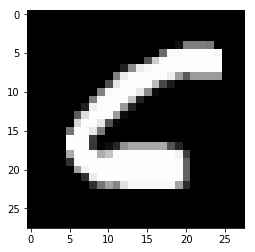

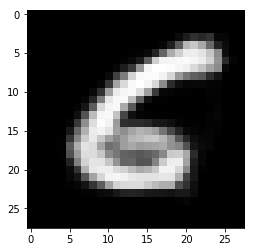

14900 -9.23299 16.0642 -25.2972


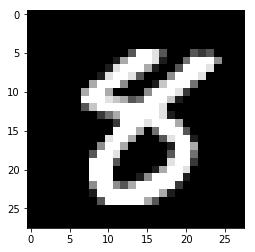

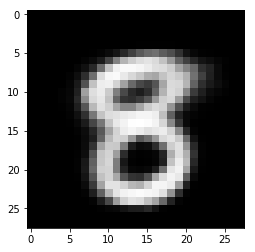

15000 -9.47188 15.821 -25.2928


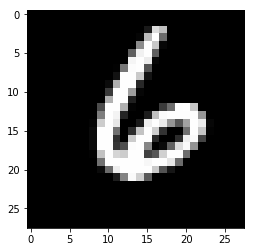

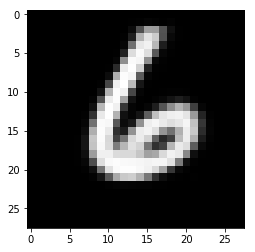

15100 -9.84731 15.6663 -25.5136


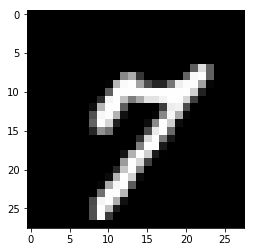

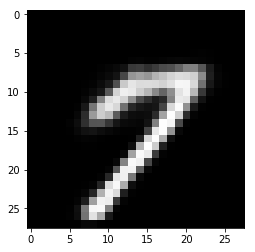

15200 -9.94193 15.4548 -25.3967


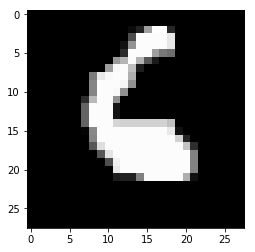

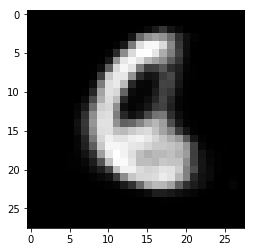

15300 -9.162 16.0447 -25.2067


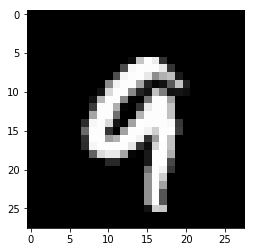

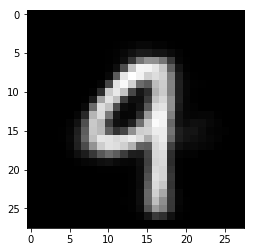

15400 -9.4282 15.7743 -25.2025


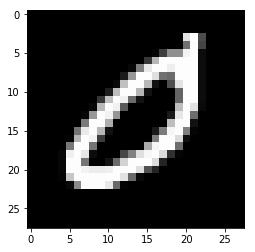

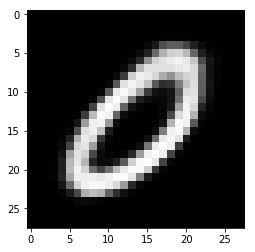

15500 -9.70414 15.9286 -25.6328


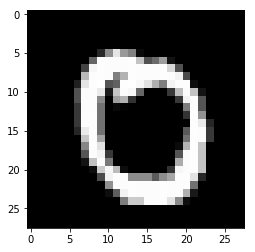

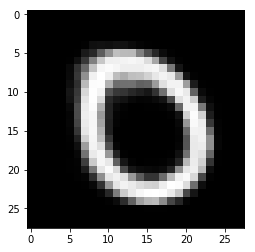

15600 -8.47719 16.6999 -25.1771


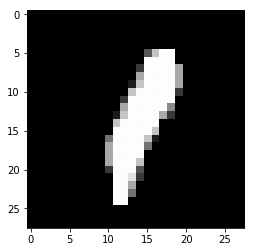

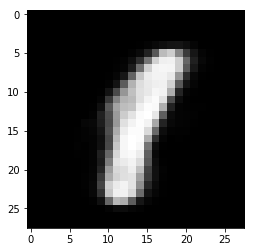

15700 -9.15401 16.2536 -25.4076


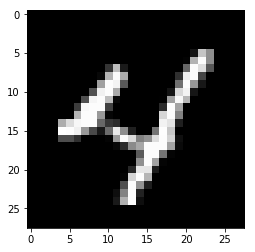

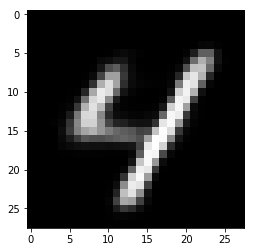

15800 -9.67634 15.2576 -24.934


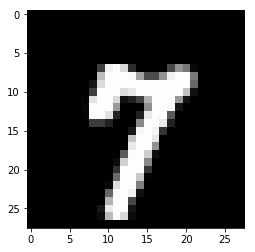

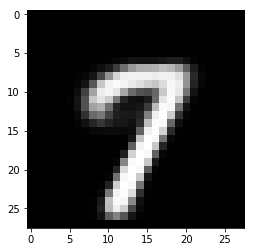

15900 -9.23669 15.6513 -24.888


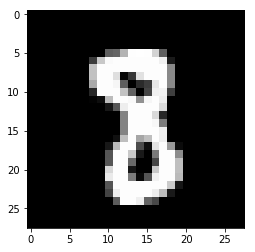

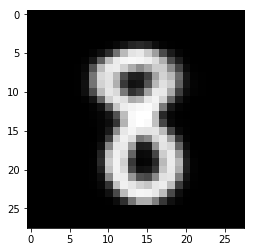

16000 -9.7645 15.6363 -25.4008


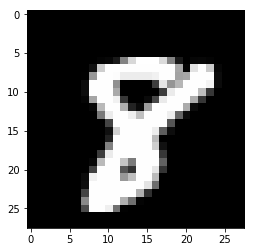

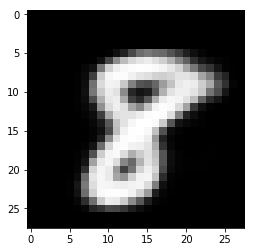

16100 -9.19316 16.0198 -25.213


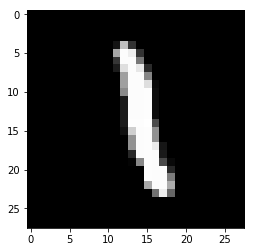

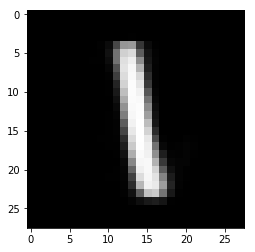

16200 -8.51244 16.7404 -25.2529


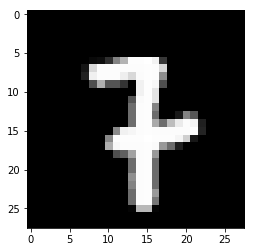

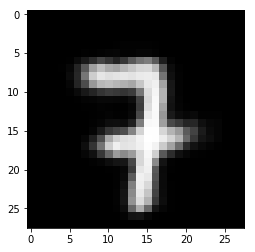

16300 -8.70713 16.4001 -25.1072


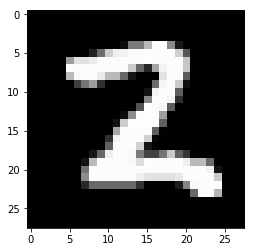

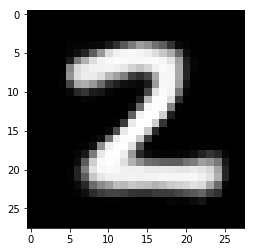

16400 -9.92459 15.3206 -25.2452


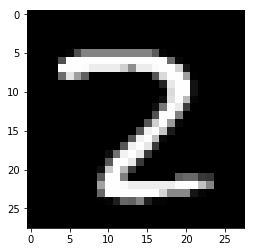

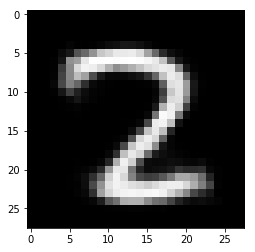

16500 -9.65273 15.4475 -25.1002


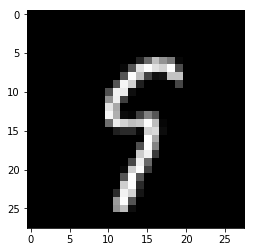

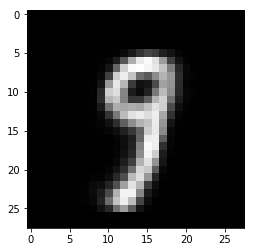

16600 -8.4906 16.795 -25.2857


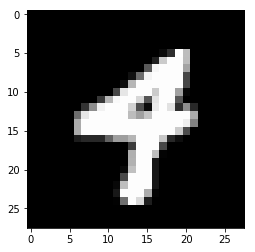

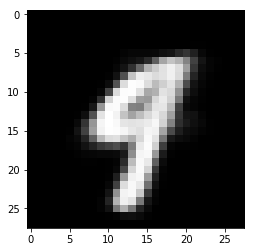

16700 -9.07826 16.0001 -25.0783


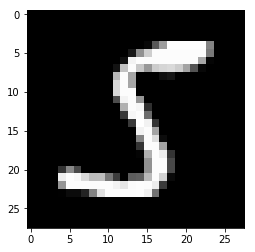

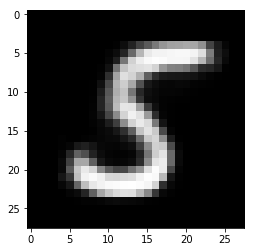

16800 -9.76867 15.383 -25.1516


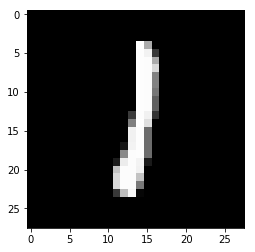

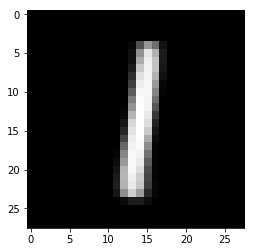

16900 -9.43994 15.6754 -25.1154


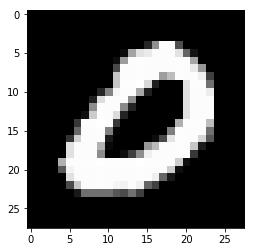

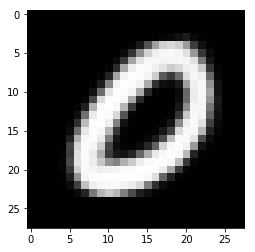

17000 -9.0301 16.0045 -25.0346


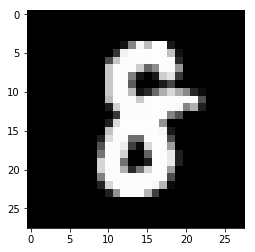

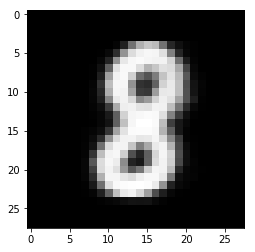

17100 -9.45885 15.678 -25.1368


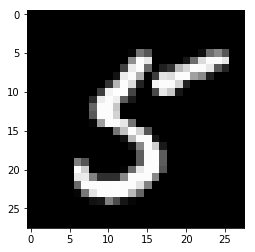

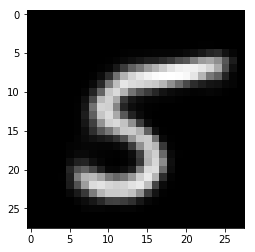

17200 -9.97954 15.1958 -25.1754


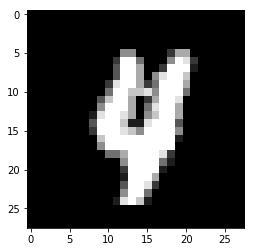

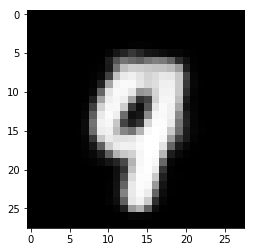

17300 -8.38979 16.3967 -24.7865


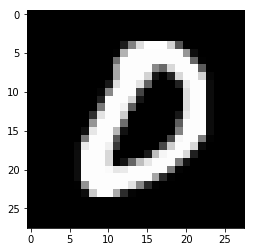

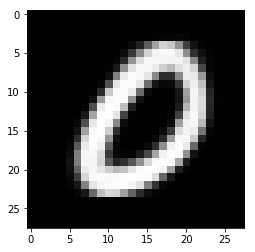

17400 -8.77736 16.4672 -25.2446


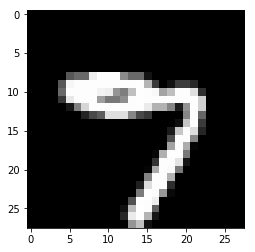

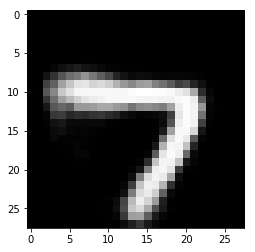

17500 -9.41291 15.3162 -24.7292


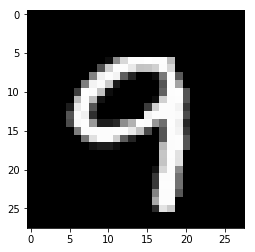

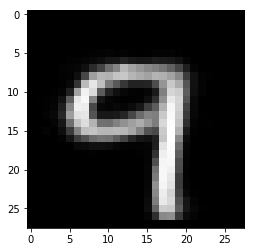

17600 -9.51255 15.894 -25.4066


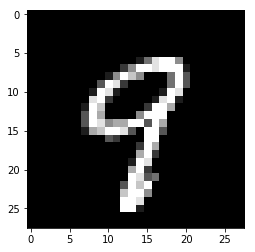

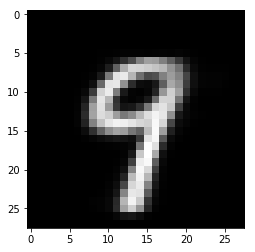

17700 -8.69812 16.27 -24.9681


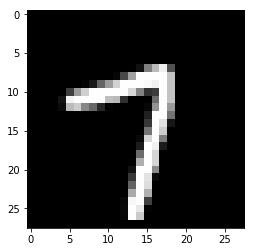

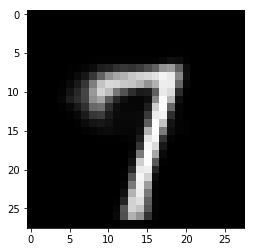

17800 -9.14697 15.8512 -24.9981


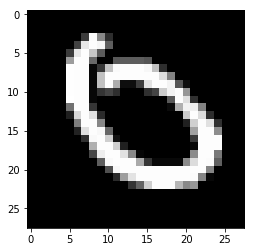

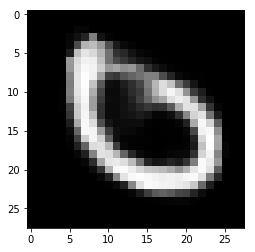

17900 -9.18373 15.8849 -25.0686


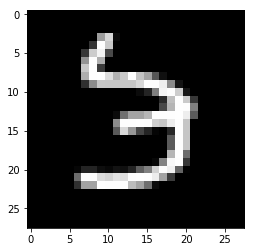

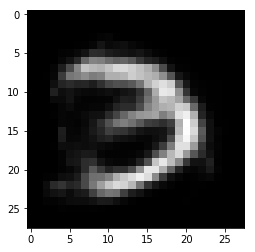

18000 -9.37039 15.6444 -25.0148


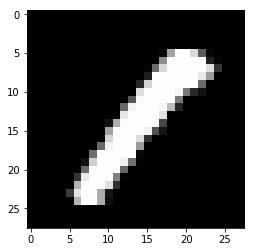

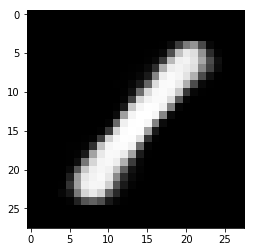

18100 -9.35641 15.2495 -24.6059


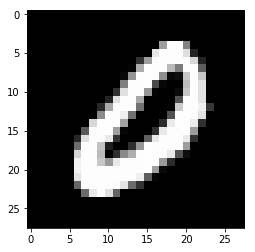

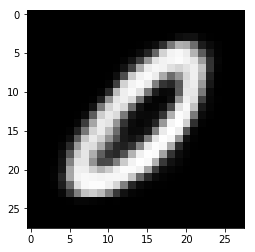

18200 -10.2338 15.0332 -25.2669


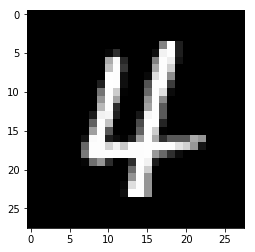

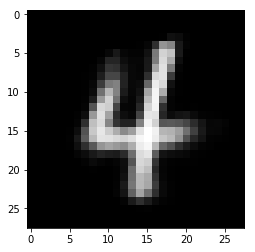

18300 -9.28254 16.0747 -25.3572


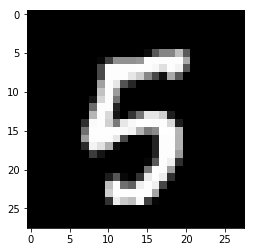

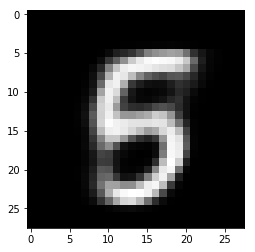

18400 -9.59437 15.7348 -25.3292


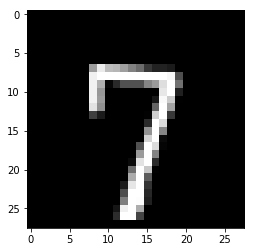

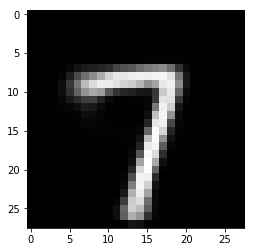

18500 -9.73655 15.4511 -25.1876


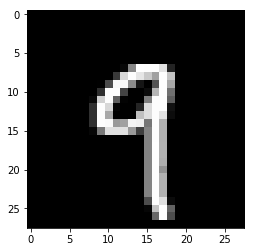

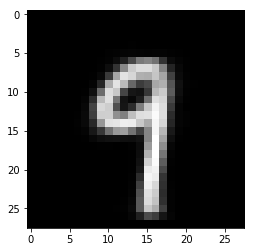

18600 -8.82695 16.1688 -24.9957


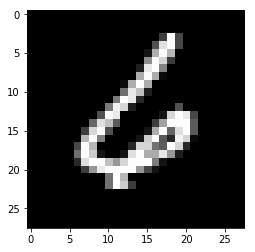

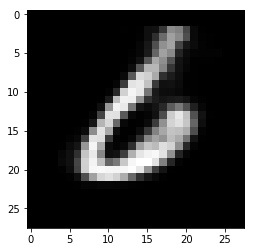

18700 -9.70572 15.4018 -25.1075


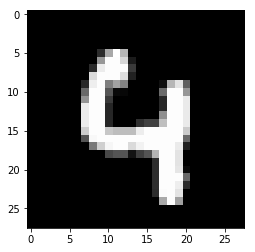

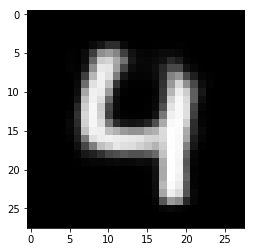

18800 -10.1074 15.0152 -25.1226


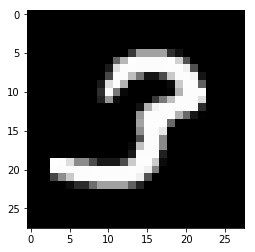

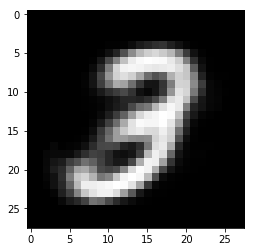

18900 -9.01908 16.2117 -25.2308


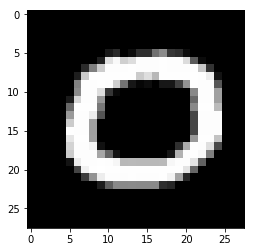

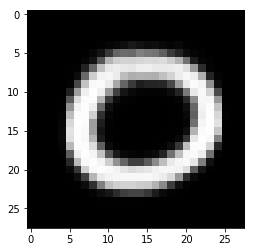

19000 -8.76601 16.2919 -25.0579


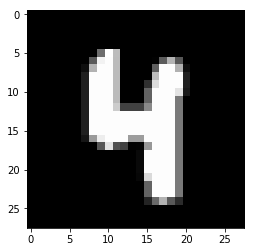

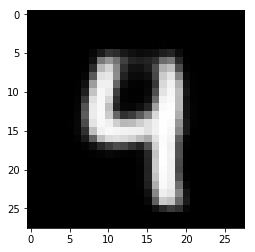

19100 -10.3326 15.0818 -25.4144


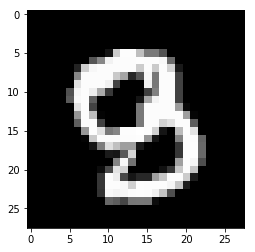

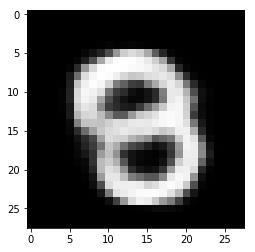

19200 -9.44983 15.6495 -25.0994


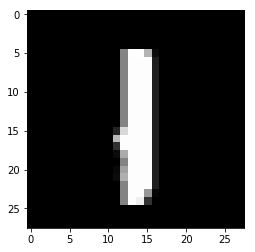

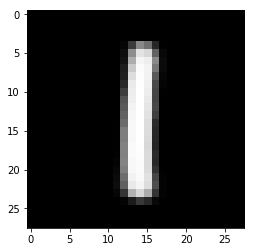

19300 -9.41735 15.7672 -25.1846


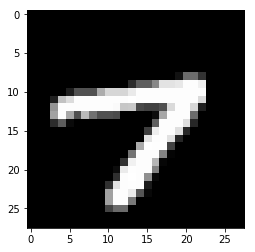

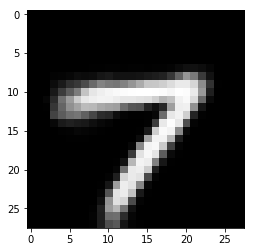

19400 -9.63666 15.2169 -24.8535


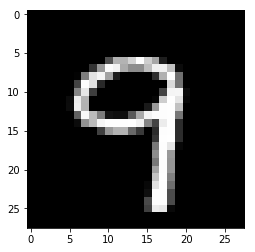

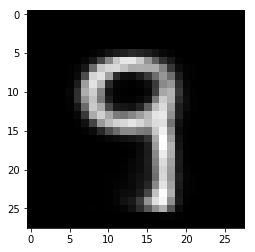

19500 -9.22931 15.7468 -24.9761


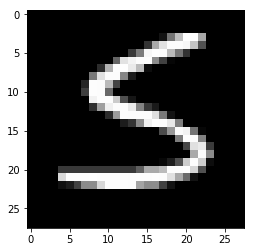

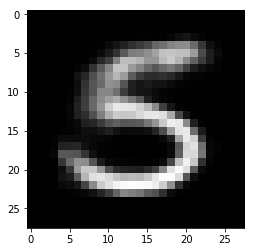

19600 -9.8358 15.307 -25.1428


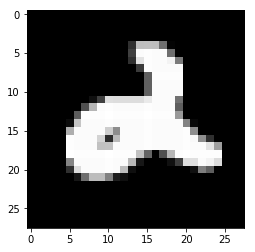

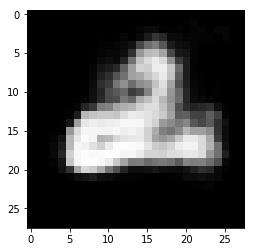

19700 -9.1768 15.6517 -24.8285


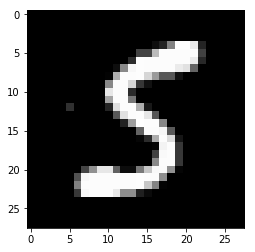

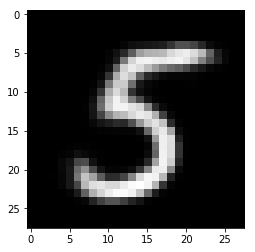

19800 -9.94617 15.1703 -25.1165


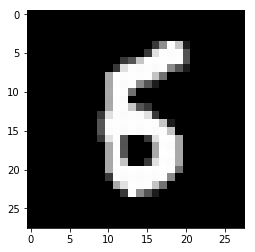

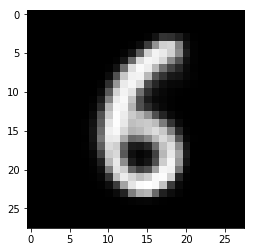

19900 -9.38874 15.8265 -25.2152


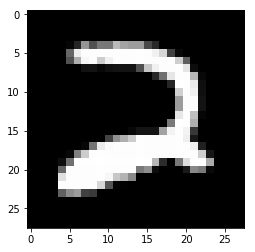

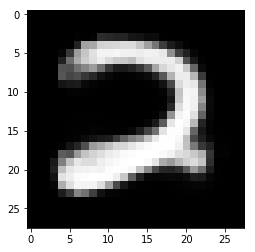

20000 -8.70941 15.9127 -24.6221


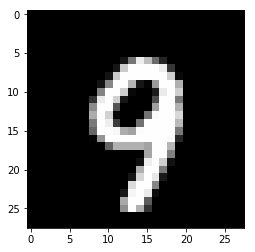

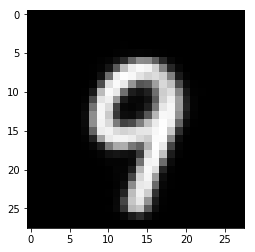

20100 -9.38711 15.5929 -24.98


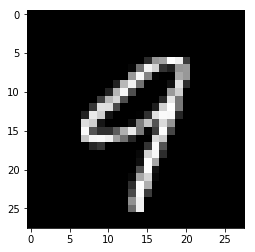

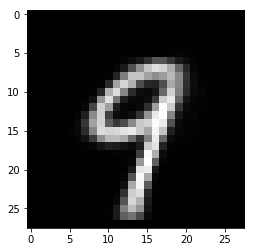

20200 -8.8405 15.9538 -24.7943


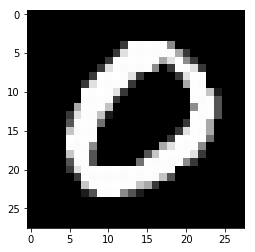

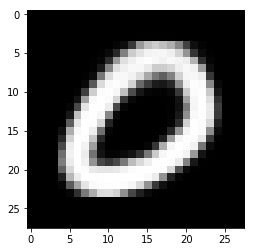

20300 -10.1697 15.2416 -25.4114


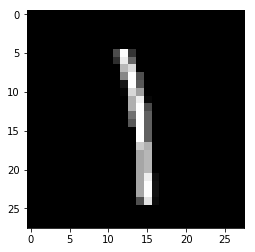

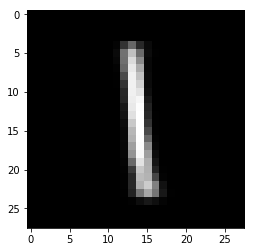

20400 -9.93622 14.8872 -24.8234


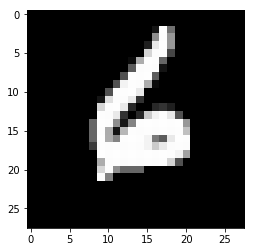

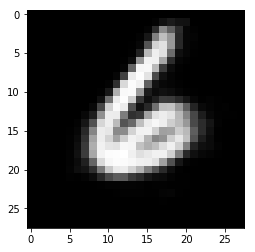

20500 -9.81938 15.4306 -25.2499


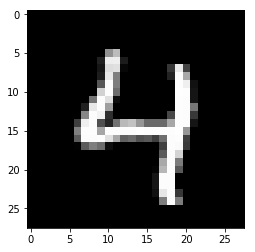

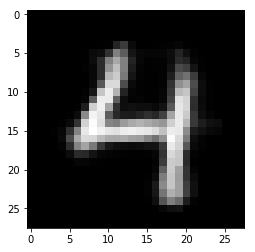

20600 -9.69682 15.5158 -25.2126


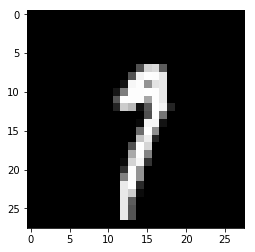

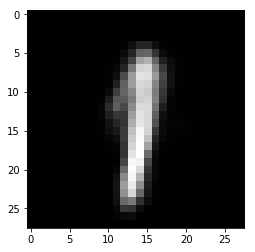

20700 -10.0327 15.2846 -25.3173


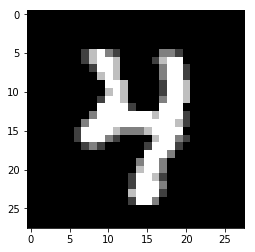

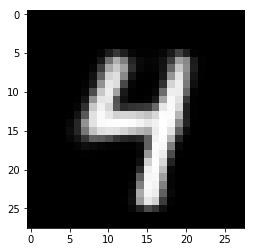

20800 -9.6085 15.6653 -25.2738


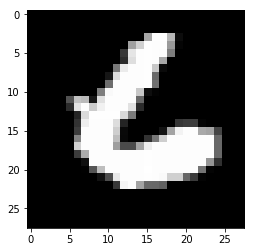

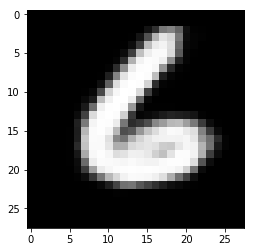

20900 -9.58216 15.6187 -25.2009


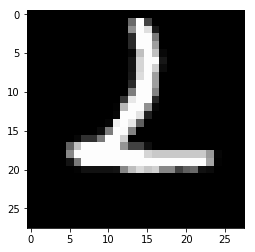

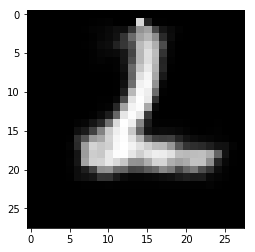

21000 -9.24883 15.8945 -25.1434


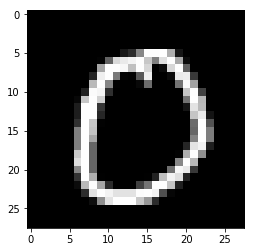

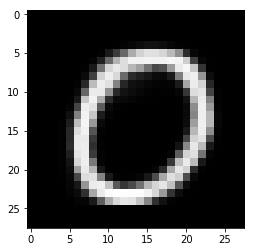

21100 -9.27879 15.6229 -24.9017


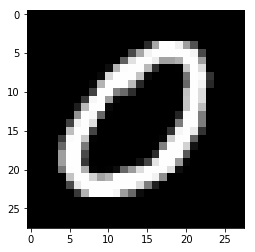

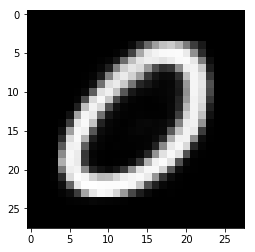

21200 -9.71338 15.4071 -25.1205


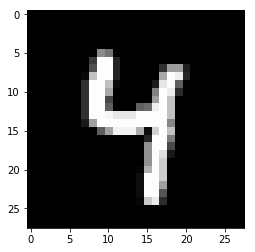

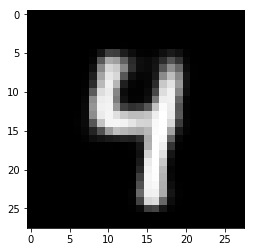

21300 -10.7289 14.3651 -25.0941


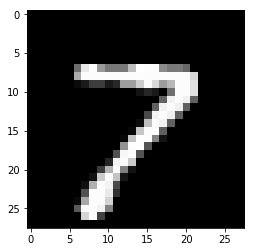

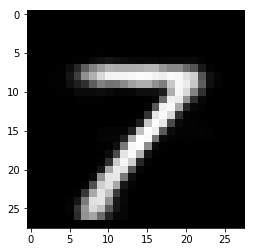

21400 -8.98338 16.0142 -24.9976


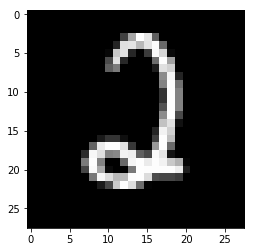

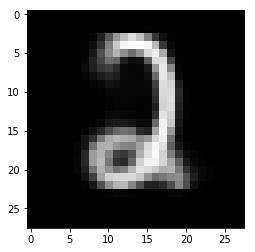

21500 -10.2225 14.6306 -24.8531


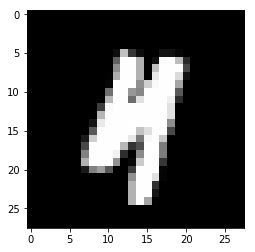

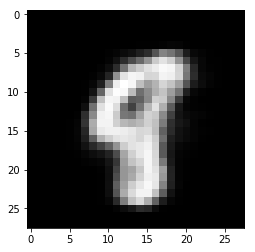

21600 -9.67755 15.5948 -25.2724


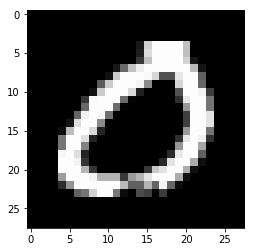

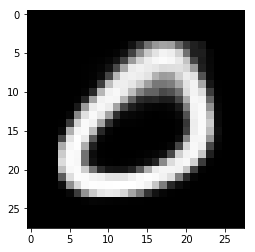

21700 -10.2351 15.1754 -25.4105


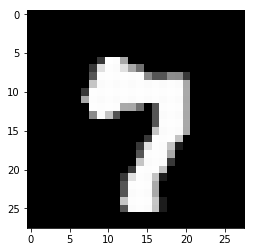

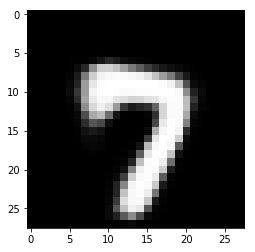

21800 -10.0065 15.0918 -25.0983


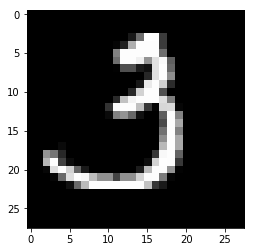

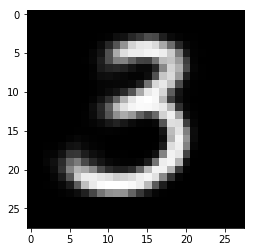

21900 -9.69963 15.5554 -25.255


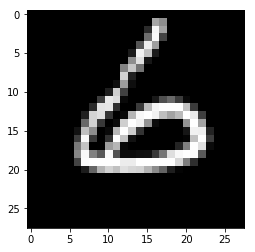

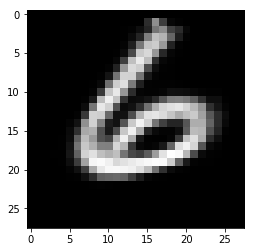

22000 -9.36058 15.5625 -24.923


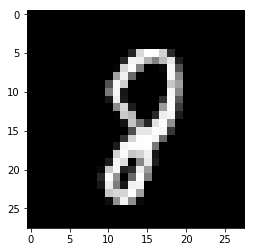

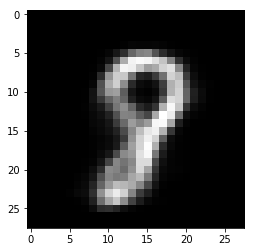

22100 -9.29945 15.8014 -25.1008


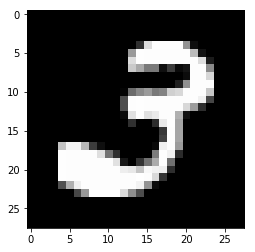

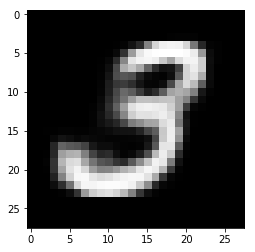

22200 -9.63577 15.5167 -25.1524


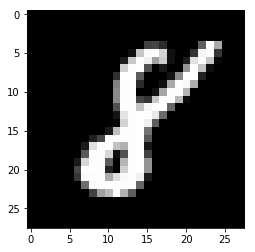

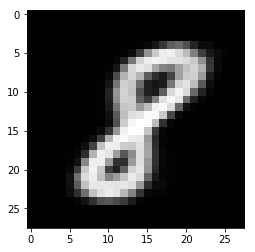

22300 -9.08468 15.899 -24.9837


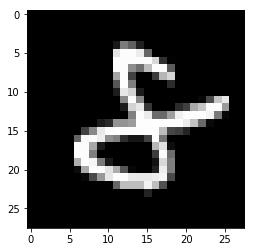

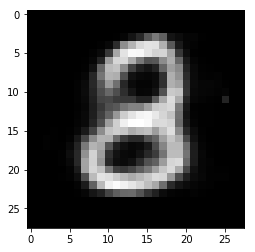

22400 -10.6392 14.6146 -25.2538


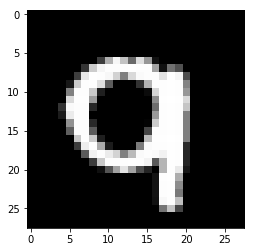

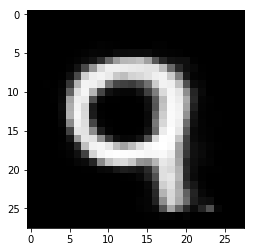

22500 -9.13477 15.7124 -24.8472


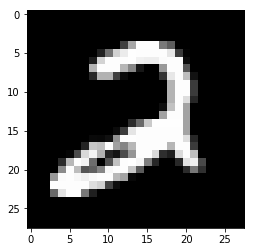

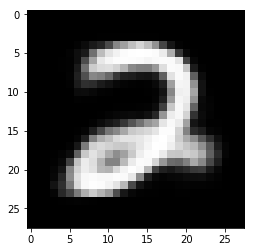

22600 -10.1102 14.8985 -25.0086


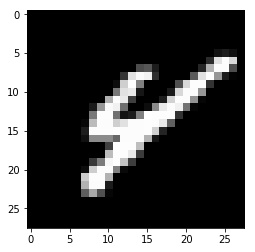

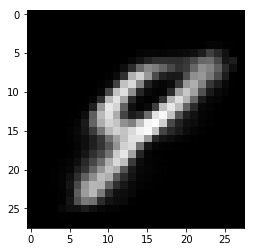

22700 -9.85405 15.1426 -24.9966


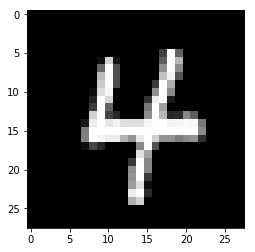

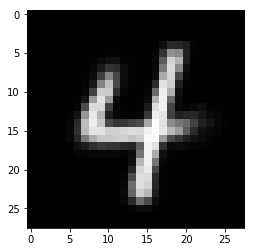

22800 -9.3853 15.4868 -24.8721


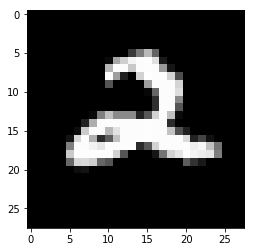

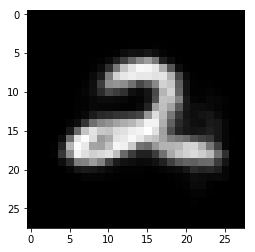

22900 -10.0996 15.1235 -25.2231


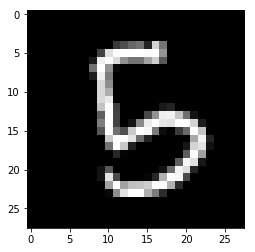

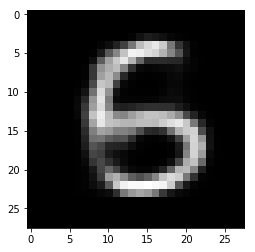

23000 -10.2923 14.3359 -24.6282


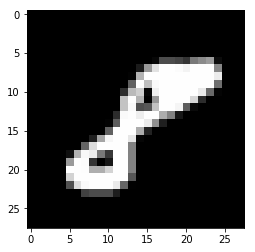

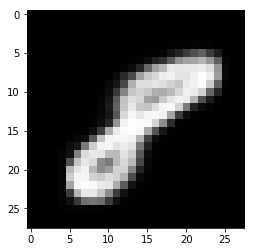

23100 -9.97378 15.2969 -25.2707


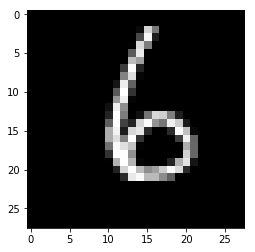

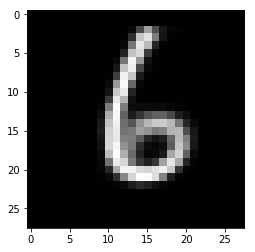

23200 -10.1035 15.1512 -25.2547


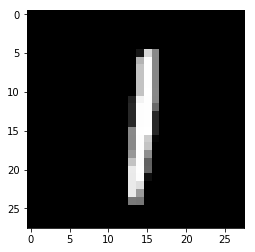

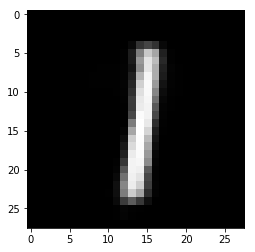

23300 -9.27792 15.9204 -25.1983


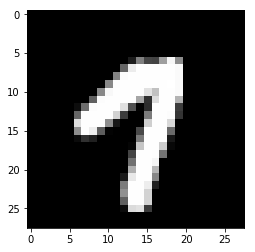

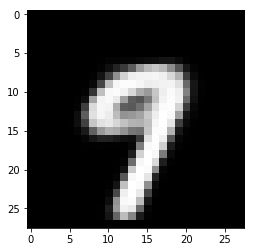

23400 -9.27391 16.0236 -25.2975


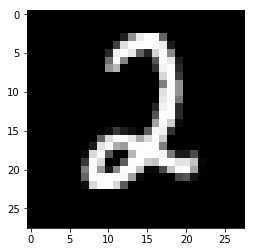

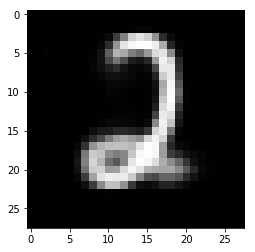

23500 -9.24574 15.5443 -24.7901


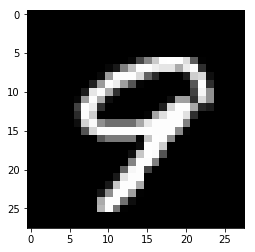

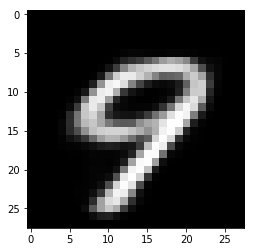

23600 -10.9655 14.3148 -25.2803


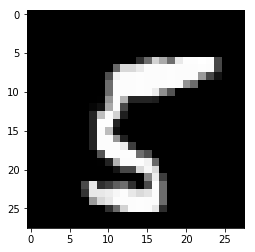

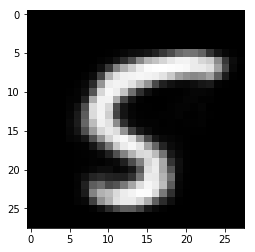

23700 -10.0203 15.1715 -25.1917


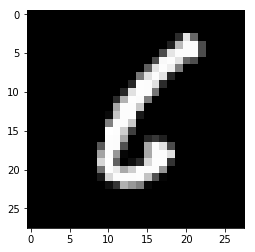

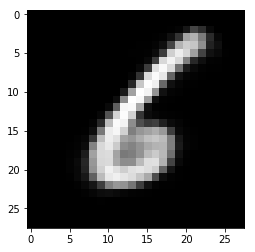

23800 -9.26362 15.6554 -24.919


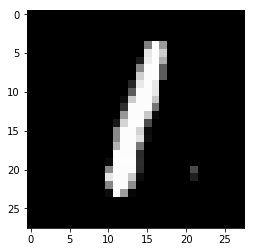

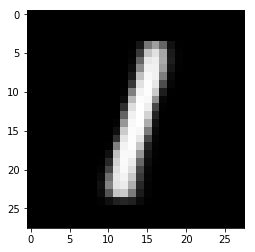

23900 -9.37686 15.8642 -25.241


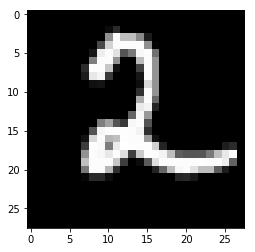

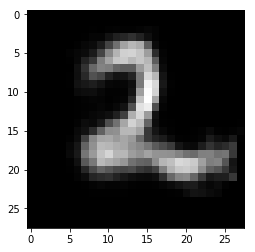

24000 -9.46061 15.2354 -24.696


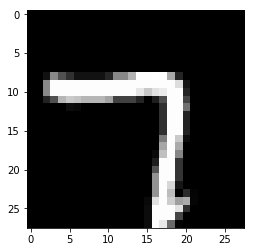

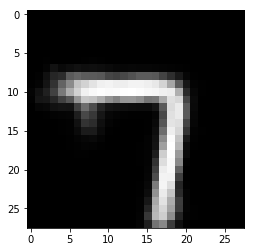

24100 -10.0882 15.0178 -25.106


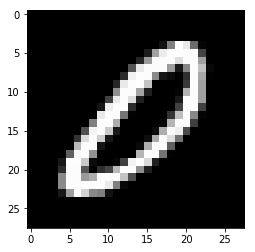

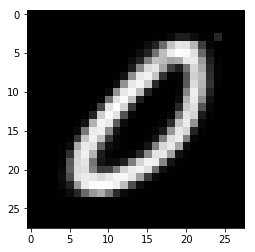

24200 -9.94746 15.1082 -25.0557


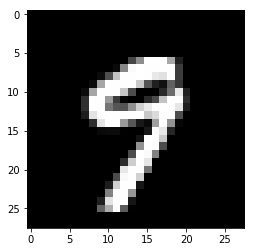

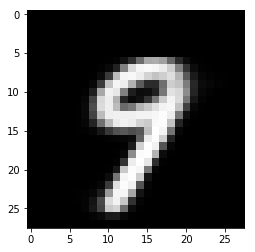

24300 -9.83196 15.1258 -24.9578


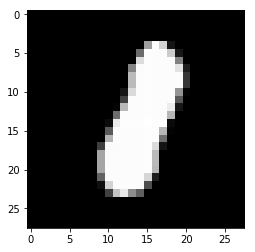

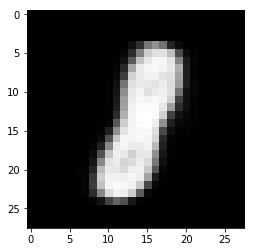

24400 -8.99134 15.632 -24.6234


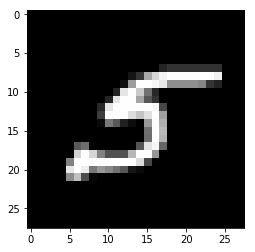

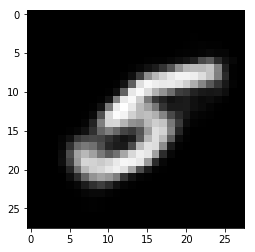

24500 -9.10497 15.6268 -24.7318


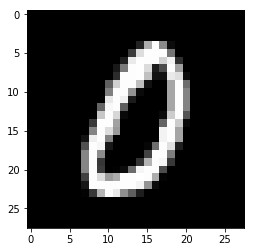

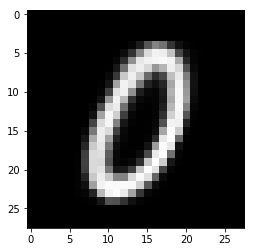

24600 -9.84889 15.2803 -25.1292


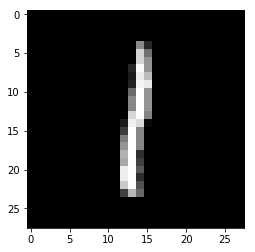

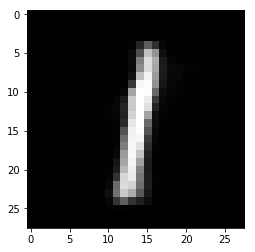

24700 -9.33879 15.6349 -24.9737


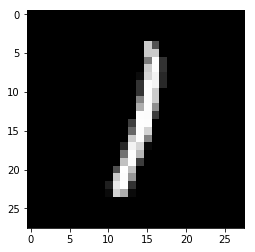

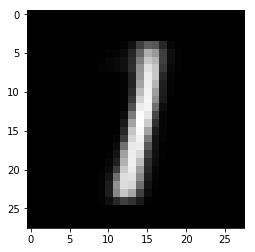

24800 -9.61091 15.2353 -24.8463


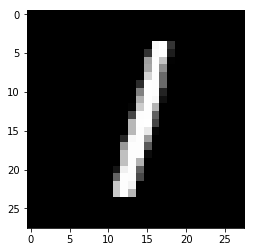

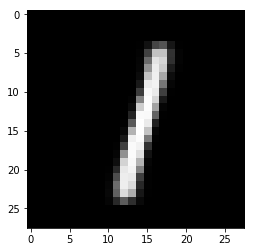

24900 -9.67815 15.0468 -24.725


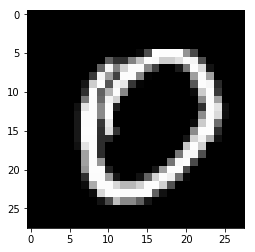

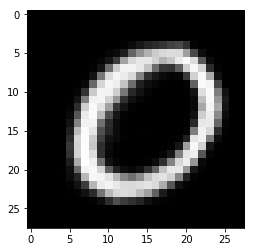

25000 -9.86487 15.0522 -24.9171


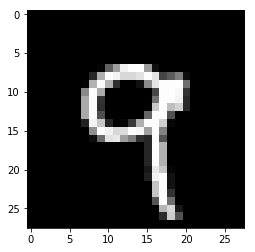

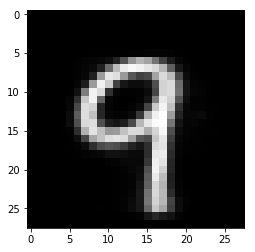

25100 -9.98393 14.9825 -24.9664


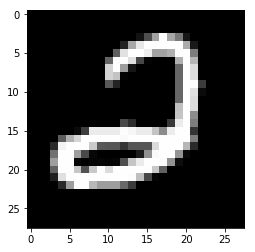

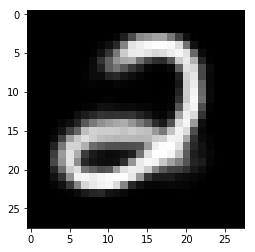

25200 -9.64676 15.1005 -24.7473


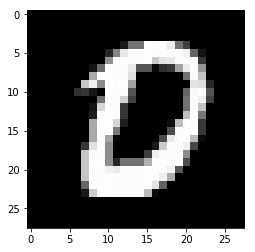

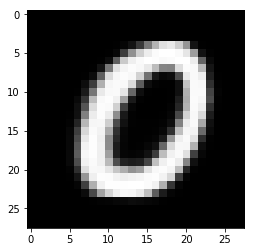

25300 -11.4517 13.8575 -25.3092


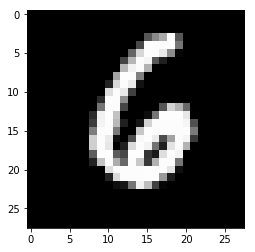

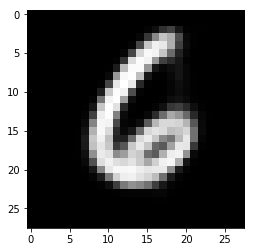

25400 -9.77565 15.0808 -24.8565


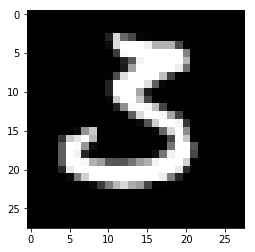

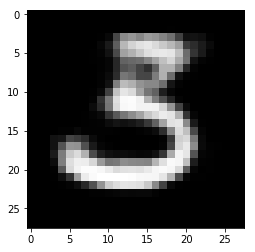

25500 -10.4951 14.7043 -25.1994


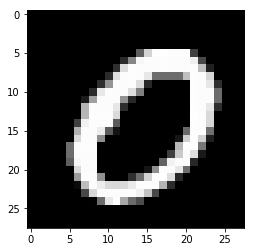

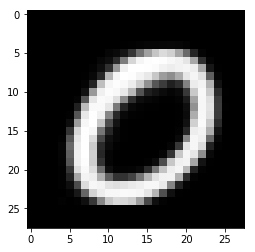

25600 -10.5573 14.5102 -25.0675


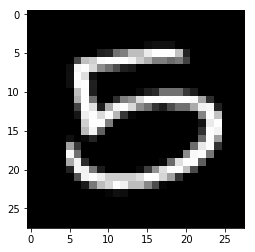

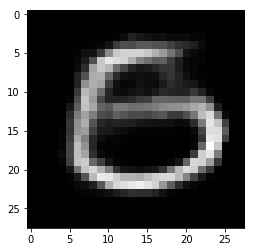

25700 -9.7075 15.1471 -24.8546


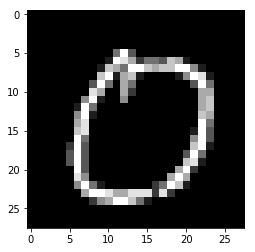

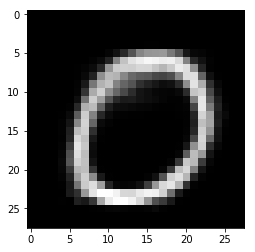

25800 -9.47215 15.1608 -24.6329


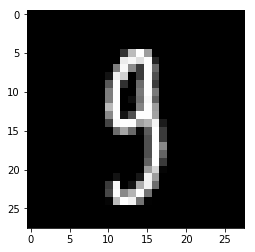

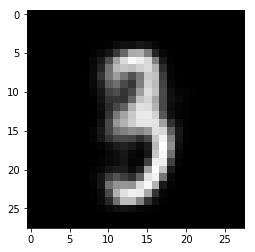

25900 -10.6065 14.7137 -25.3202


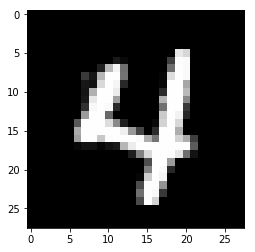

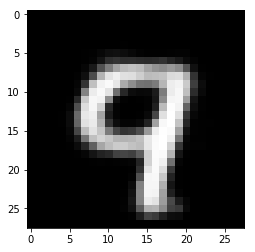

26000 -10.4334 14.654 -25.0875


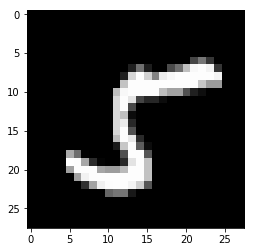

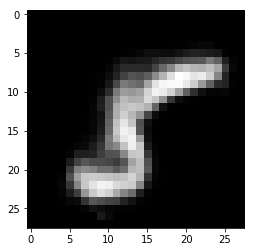

26100 -10.614 14.5384 -25.1524


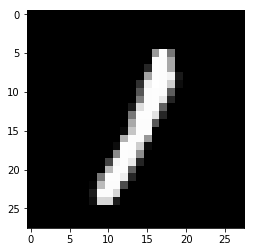

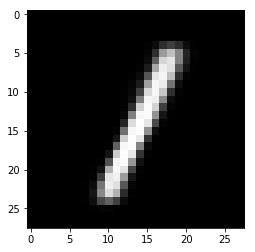

26200 -9.76559 15.1174 -24.883


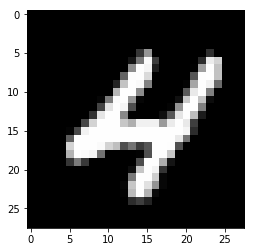

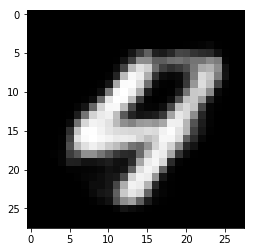

26300 -9.70193 15.1908 -24.8927


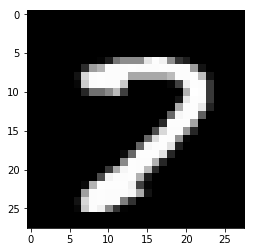

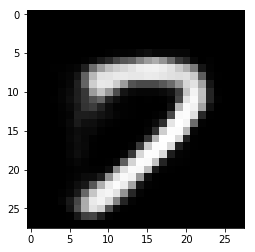

26400 -8.93419 16.3488 -25.283


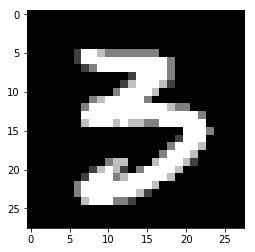

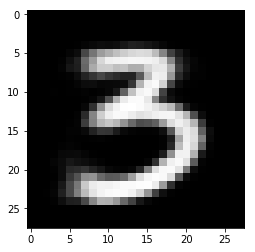

26500 -9.80653 15.2157 -25.0223


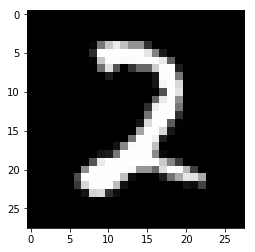

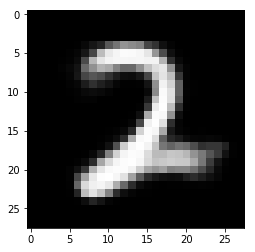

26600 -8.97541 15.8161 -24.7915


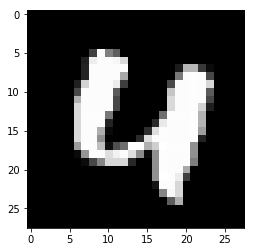

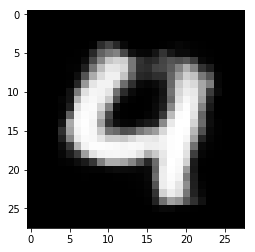

26700 -10.1196 14.8168 -24.9364


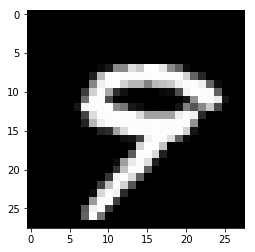

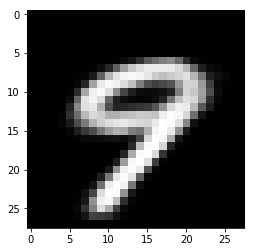

26800 -10.105 15.0142 -25.1192


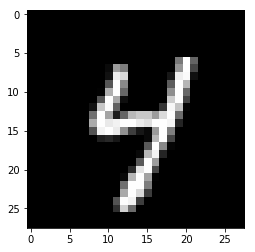

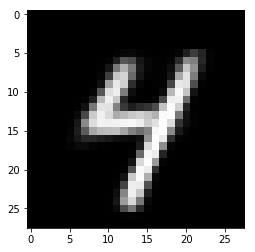

26900 -9.92092 15.0501 -24.971


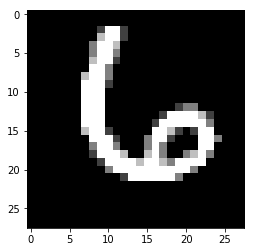

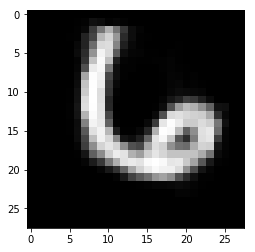

27000 -8.85189 15.8746 -24.7264


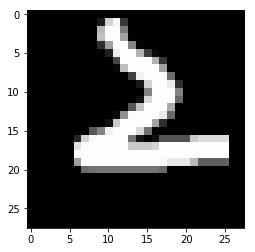

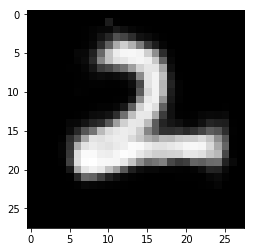

27100 -10.147 14.4003 -24.5472


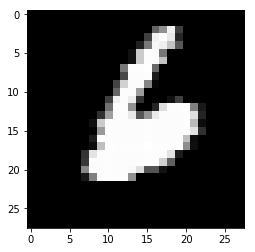

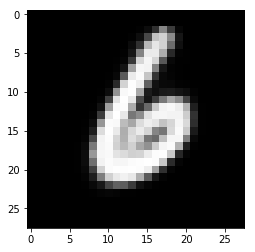

27200 -9.12057 15.7564 -24.877


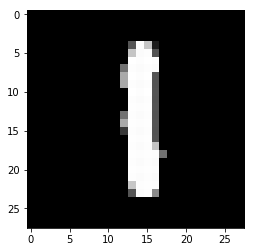

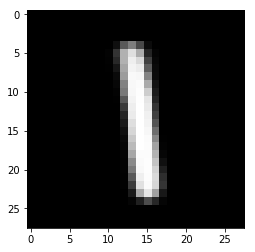

27300 -10.3692 14.4595 -24.8287


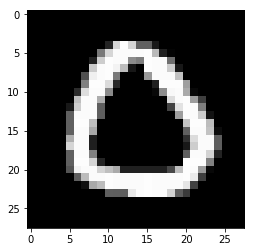

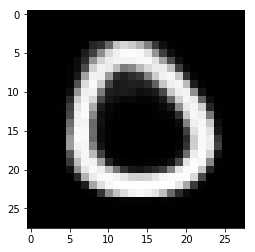

27400 -9.78292 15.1873 -24.9702


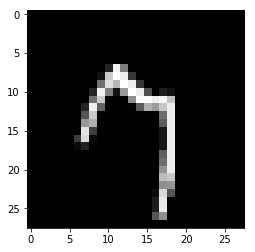

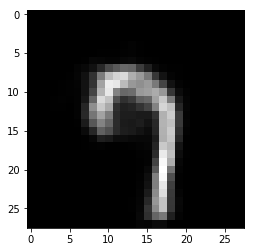

27500 -10.0082 14.987 -24.9952


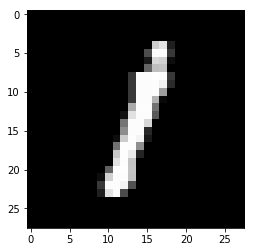

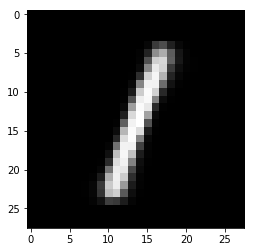

27600 -9.5275 15.5568 -25.0843


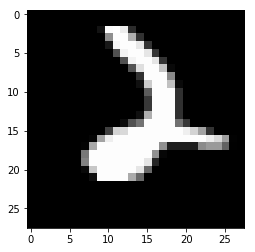

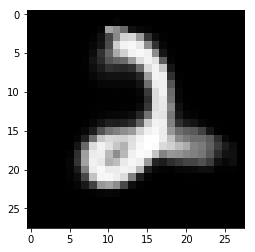

27700 -9.76126 15.2822 -25.0435


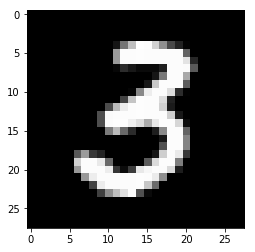

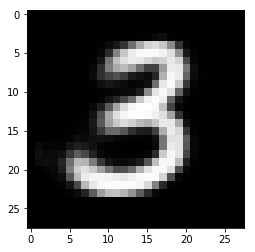

27800 -10.0706 14.8878 -24.9584


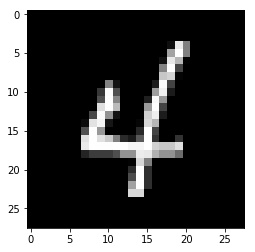

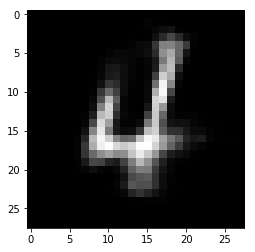

27900 -8.64028 15.8793 -24.5196


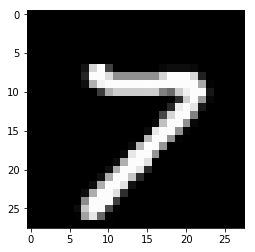

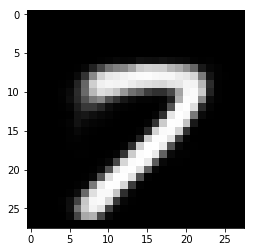

28000 -10.0678 14.911 -24.9788


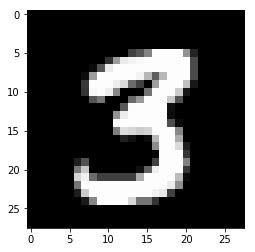

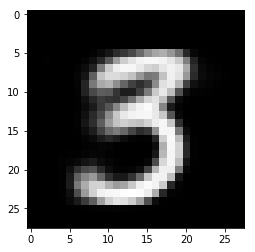

28100 -9.75123 15.3896 -25.1409


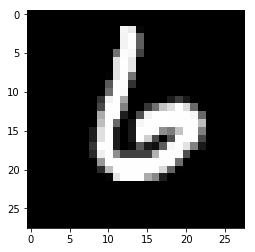

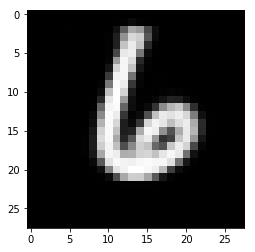

28200 -9.84884 15.081 -24.9299


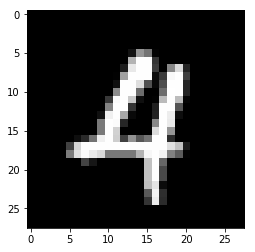

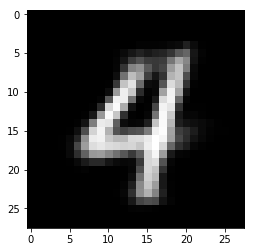

28300 -10.2464 14.959 -25.2054


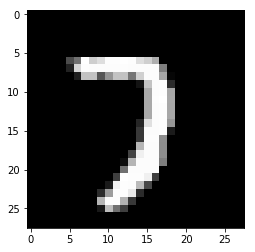

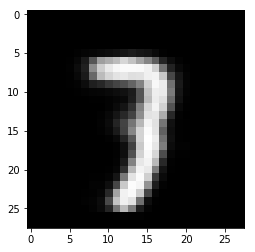

28400 -9.77857 14.9904 -24.769


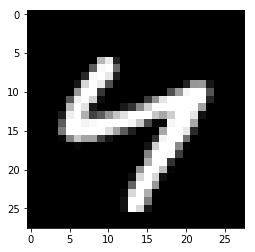

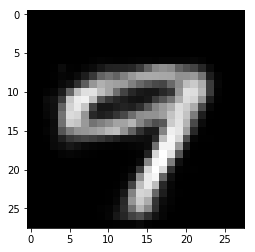

28500 -8.6303 15.96 -24.5903


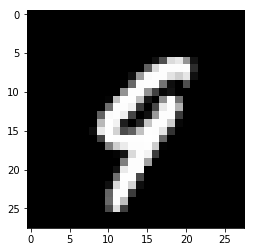

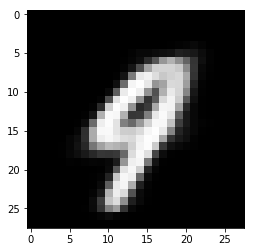

28600 -9.69289 14.9563 -24.6492


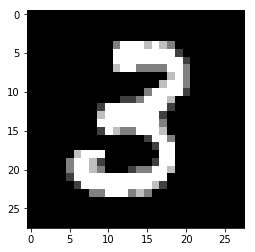

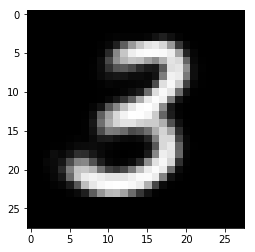

28700 -10.1603 14.6549 -24.8151


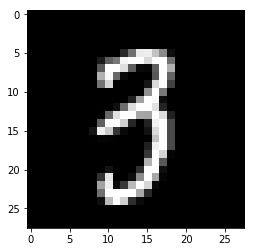

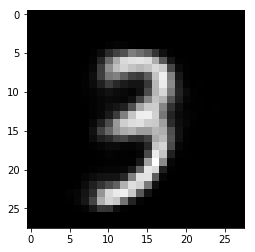

28800 -9.33939 15.8212 -25.1606


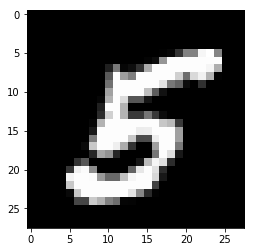

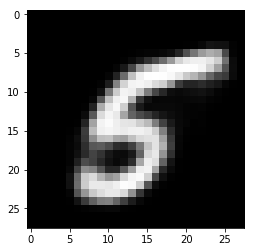

28900 -9.57861 15.2759 -24.8545


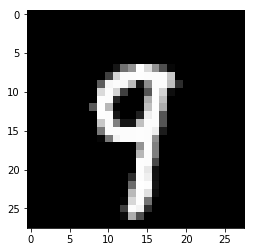

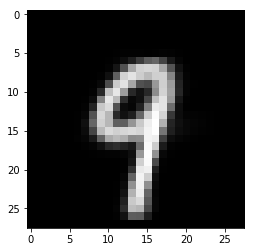

29000 -10.0272 15.0728 -25.1


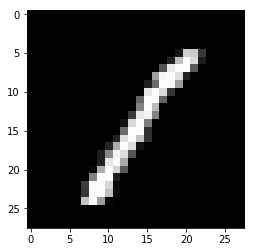

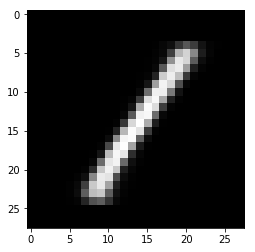

29100 -9.1366 15.5863 -24.7229


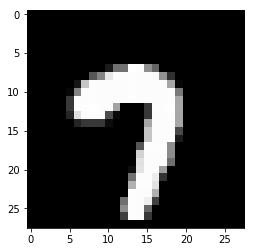

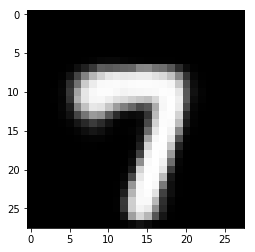

29200 -10.7083 14.2489 -24.9572


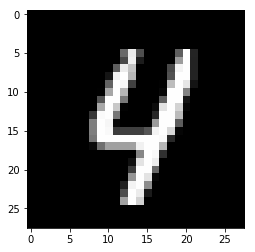

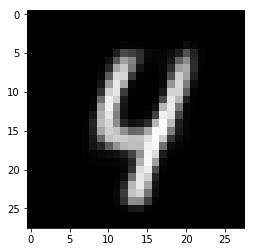

29300 -9.7979 15.1146 -24.9125


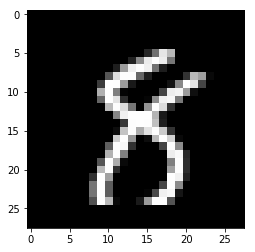

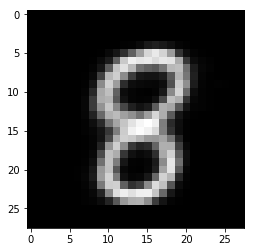

29400 -10.4551 14.7567 -25.2117


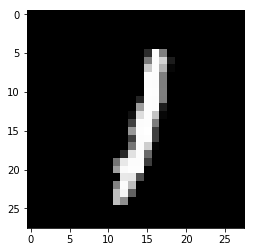

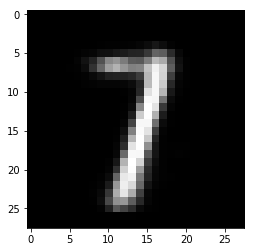

29500 -10.0121 15.2348 -25.2469


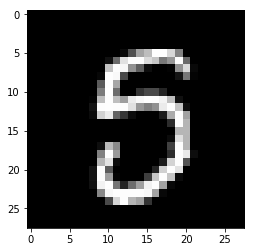

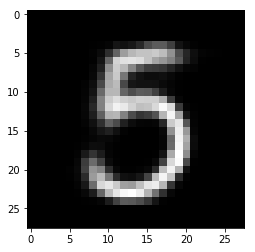

29600 -10.5316 14.305 -24.8365


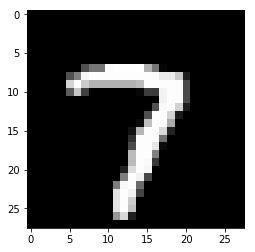

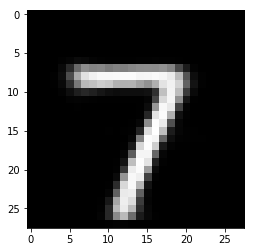

29700 -10.9917 14.2613 -25.253


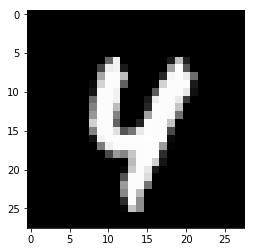

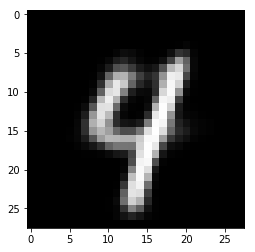

29800 -10.2855 14.3939 -24.6794


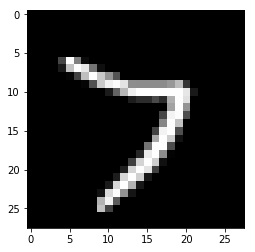

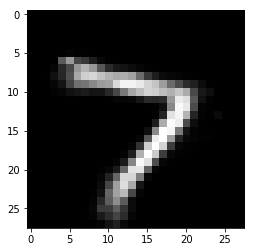

29900 -10.0278 14.7413 -24.7691
Wall time: 23min 29s


In [8]:
%%time
for i in range(30000):
    batch = [np.reshape(b,[28,28]) for b in mnist.train.next_batch(batch_size=batchSize)[0]]
    sess.run(optimizer, feed_dict={XIn: batch, Y: batch, keepProb:0.8})
    
    if not i % 100:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, imgLoss, latentLoss, mn, sd],
                                               feed_dict = {XIn: batch, Y: batch, keepProb: 1.0})
        plt.imshow(np.reshape(batch[0],[28,28]),cmap = 'gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()

        print(i,ls,np.mean(i_ls), np.mean(d_ls))

## Sampling

In [49]:
%%time
sampleSize = 10
randoms = [np.random.normal(0,1,nLatent) for _ in range(sampleSize*sampleSize)]
imgs = sess.run(dec, feed_dict = {sample: randoms, keepProb: 1.0})
imgs = [np.reshape(imgs[i],[28,28]) for i in range(len(imgs))]

Wall time: 43.1 ms


## Visualization

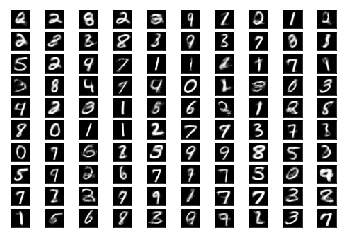

Wall time: 2.52 s


In [50]:
%%time

fig, axes = plt.subplots(sampleSize, sampleSize)
for i, ax in  enumerate (axes.ravel()):
    ax.matshow(imgs[i], cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())    
plt.show()